# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

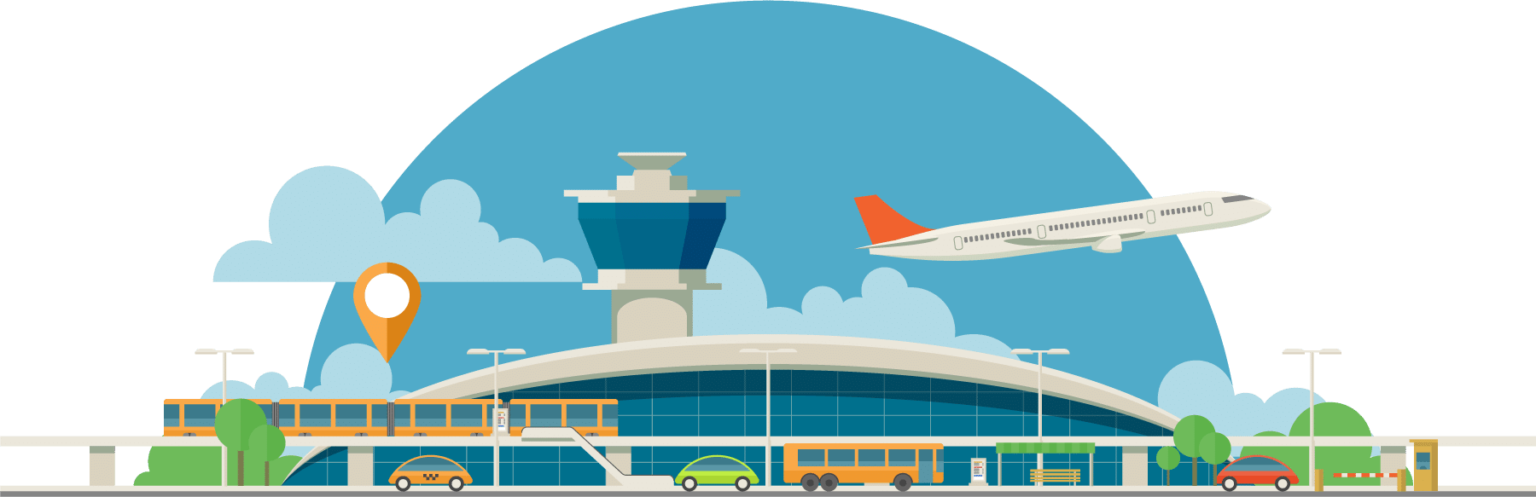

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
!pip install xgboost
!brew install cmake libomp
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f4c37972937ada453e2735b3cceee894f1747313d6b320e0fa5e7282a86ac693
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.4 MB/s eta 0:00:00
/bin/bash: line 1: brew: command not found


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-03-10 19:21:04--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-03-10 19:21:05 (2.00 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

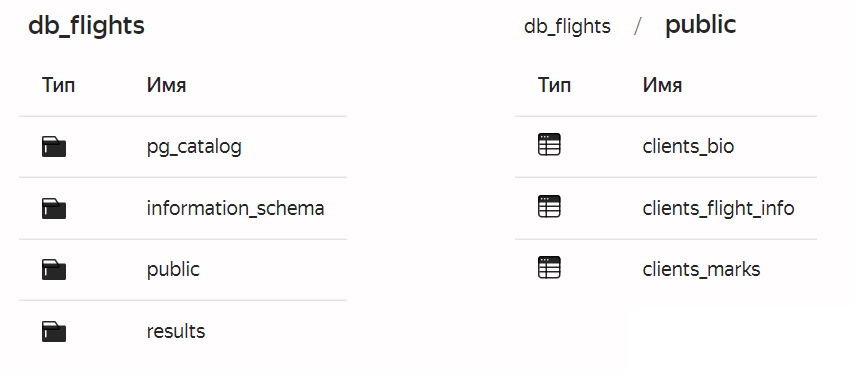



In [4]:
import pandas.io.sql as sqlio
import psycopg2

with psycopg2.connect(dbname="db_flights", user="mlhs_student", password="mlhs_student", host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net", port="6432", sslmode="verify-full") as conn:
  with conn.cursor() as cursor:
    sql = "SELECT * FROM clients_bio c JOIN clients_flight_info f ON c.id = f.id JOIN clients_marks m ON c.id = m.id"
    df = sqlio.read_sql_query(sql, conn)



<ipython-input-4-d0940d1e3753>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql, conn)


In [5]:
col = list(df.columns)
col[3] = 'id_1'
col[10] = 'id_2'
df.columns = col

df = df.set_index('id')
df = df.drop(['id_1', 'id_2'], axis = 1)


In [6]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [7]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [8]:
#import pandas as pd
pd.set_option('display.max_columns', None)

In [9]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  \
id                                                           
7                    3.0                               3.0   
13                   2.0                               2.0   
18                   2.0                               5.0   
31                   2.0                               2.0   
39                   3.0                               3.0   

   Ease of Online booking Gate location Food and drink Online boarding  \
id                                                                       
7                     3.0           3.0            5.0             4.0   
13                    2.0           4.0            5.0             2.0   
18                    2.0           1.0            4.0             1.0   
31                    2.0           1.0            2.0             2.0   
39                    3.0           3.0            4.0             5.0   

   Seat comfort Inflight entertainment On-board service Leg room service  \
id                                                                         
7           5.0                    5.0              5.0              5.0   
13          5.0                    5.0              2.0              4.0   
18          5.0                    5.0              5.0              2.0   
31          2.0                    2.0              4.0              5.0   
39          4.0                    4.0              4.0              4.0   

   Baggage handling Checkin service Inflight service cleanliness  \
id                                                                 
7               5.0             4.0              5.0         4.0   
13              4.0             2.0              4.0         5.0   
18              5.0             5.0              5.0         1.0   
31              5.0             5.0              4.0         2.0   
39              4.0             5.0              4.0         5.0   

               satisfaction  
id                           
7                 satisfied  
13  neutral or dissatisfied  
18  neutral or dissatisfied  
31  neutral or dissatisfied  
39                satisfied

In [10]:
num_col = list(df.columns)
num_col.remove('gender')
num_col.remove('Customer Type')
num_col.remove('Type of Travel')
num_col.remove('class')
num_col.remove('satisfaction')


In [11]:
df[num_col] = df[num_col].astype('float32')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float32
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float32
 6   Departure Delay in Minutes         129442 non-null  float32
 7   Arrival Delay in Minutes           129042 non-null  float32
 8   Inflight wifi service              129505 non-null  float32
 9   Departure/Arrival time convenient  129500 non-null  float32
 10  Ease of Online booking             129506 non-null  float32
 11  Gate location                      129512 no

In [13]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.921997                   15.809027   
std        20.375488      4517.670410                   93.285690   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656500               2.732327   
std                  109.242867               1.360120   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760721   
std                             1.558873                1.431009   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312708        1.357134         1.381185       1.350396   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366994          1.335521          1.361908   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.221703         1.298773          1.218819       1.346961  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [14]:
df.describe(include='object')

gender   Customer Type   Type of Travel     class  \
count   129549          129549           129549    129549   
unique       2               3                3         4   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

In [15]:
for t in ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']:
  display(df[t].value_counts())

gender
Female    65726
Male      63823
Name: count, dtype: int64

Customer Type
Loyal Customer       105763
disloyal Customer     23709
nan                      77
Name: count, dtype: int64

Type of Travel
Business travel    89405
Personal Travel    40043
nan                  101
Name: count, dtype: int64

class
Business    61939
Eco         58115
Eco Plus     9379
nan           116
Name: count, dtype: int64

satisfaction
neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: count, dtype: int64

Пропуски в датафрейме есть.
Выбросы в числовых признаках есть (возрасть 621). В категориальных признаках выбросов нет (я не считаю 'nan', '-' за выбросы).

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

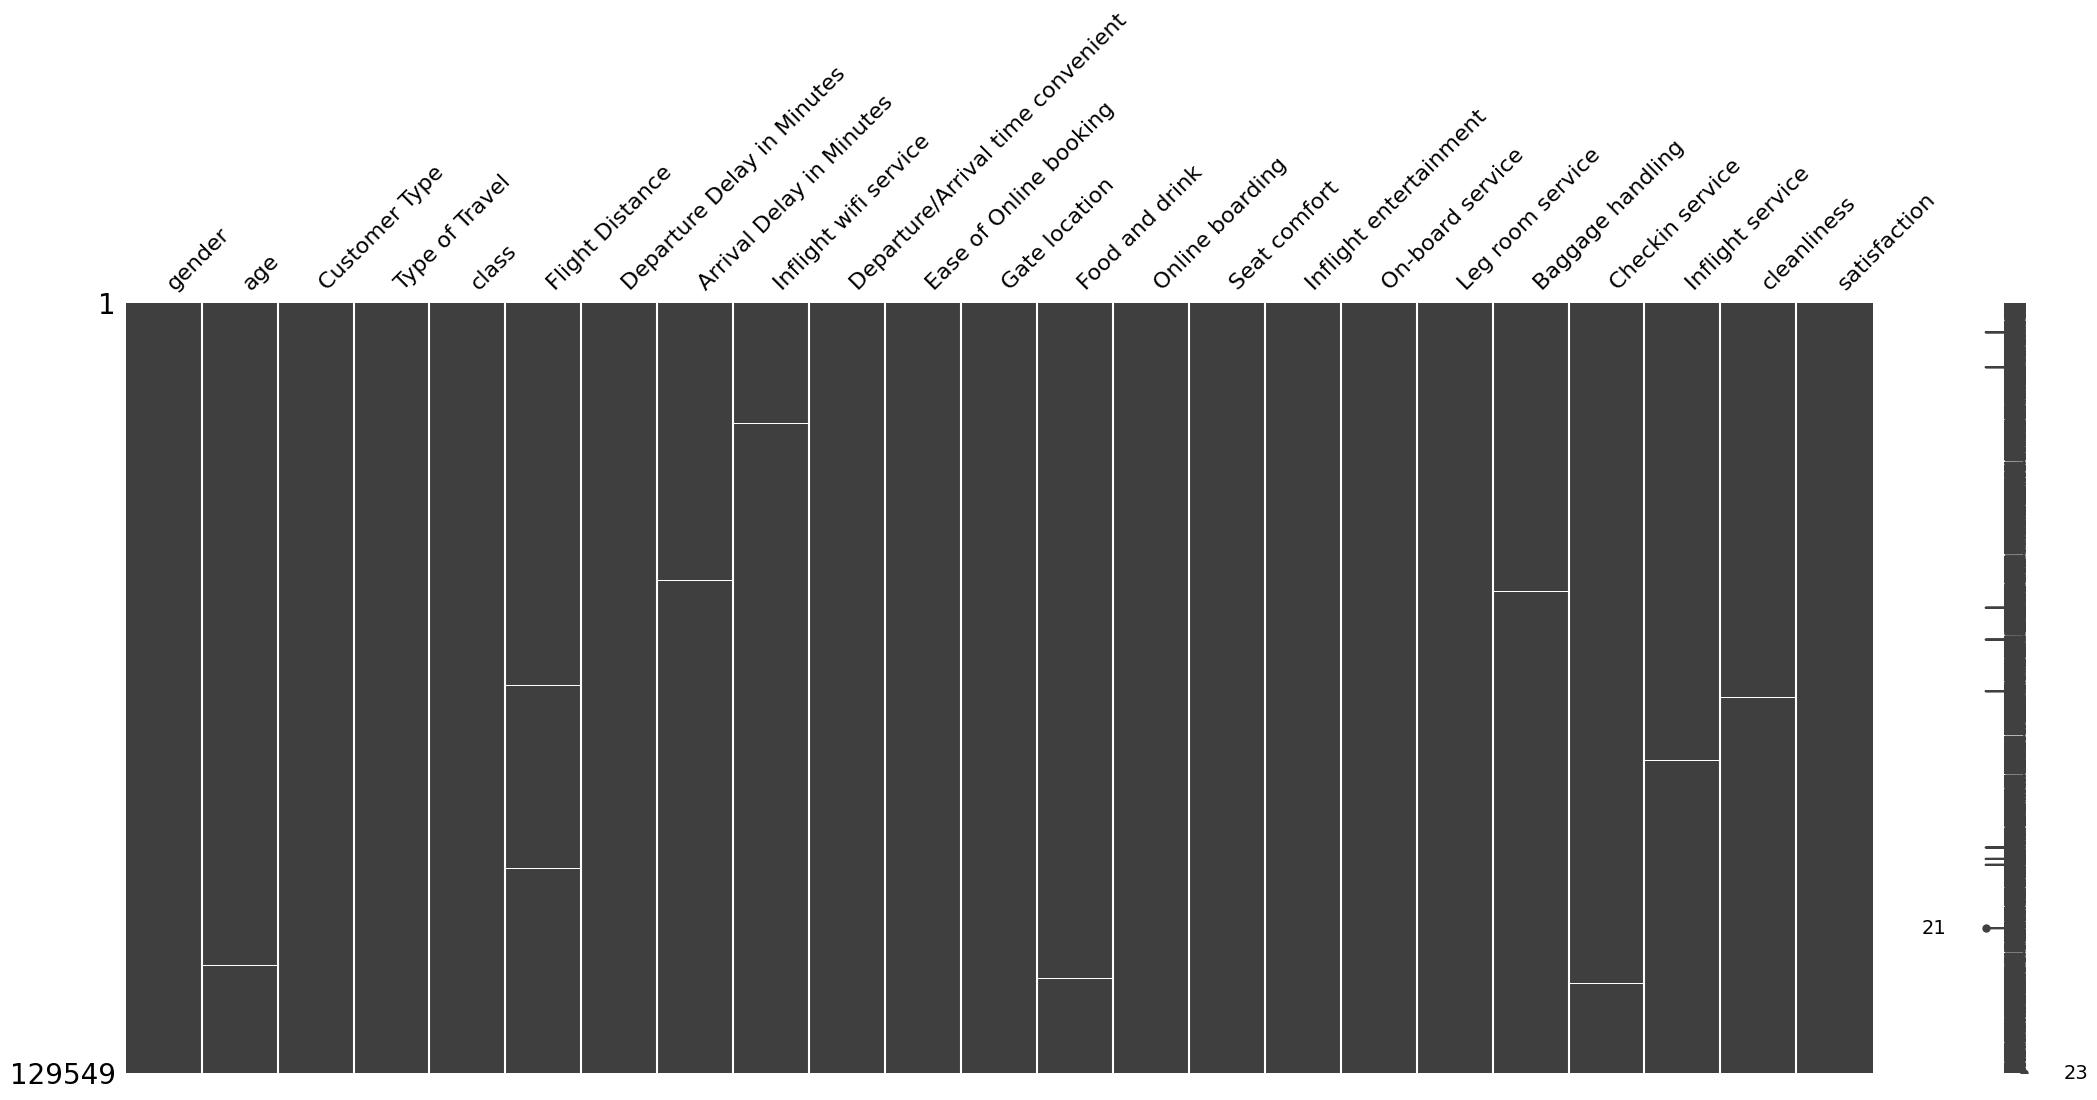

In [16]:
missingno.matrix(df)


/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

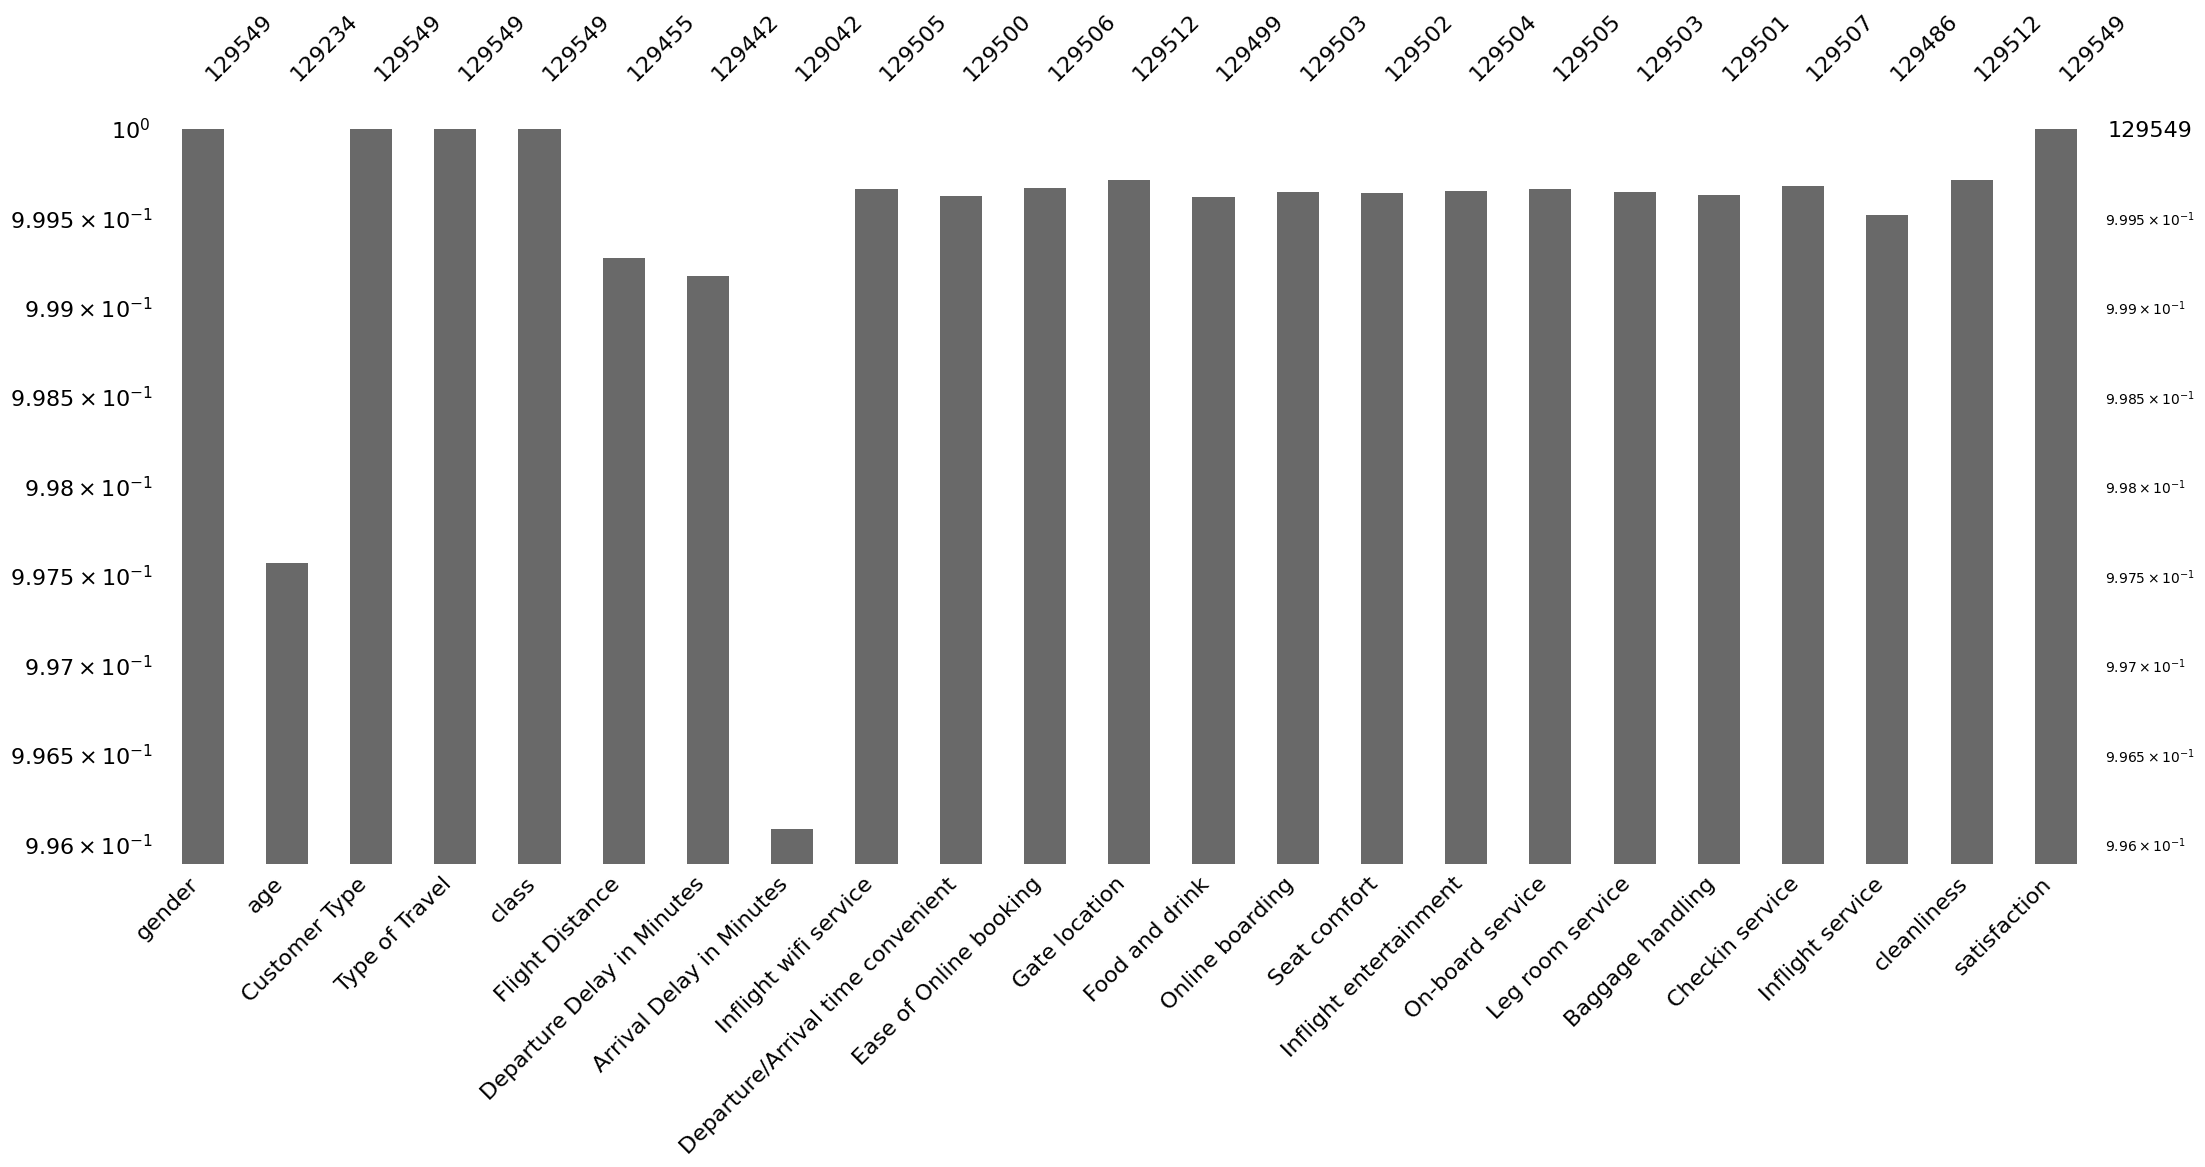

In [17]:
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [18]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
7                         3.0                                3.0   
13                        2.0                                2.0   
18                        2.0                                5.0   
31                        2.0                                2.0   
39                        3.0                                3.0   
...                       ...                                ...   
129831                    1.0                                3.0   
129837                    2.0                                4.0   
129838                    3.0                                5.0   
129839                    2.0                                4.0   
129846                    2.0                                5.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
7                          3.0            3.0             5.0   
13                         2.0            4.0             5.0   
18                         2.0            1.0             4.0   
31                         2.0            1.0             2.0   
39                         3.0            3.0             4.0   
...                        ...            ...             ...   
129831                     1.0            5.0             3.0   
129837                     2.0            3.0             2.0   
129838                     3.0            4.0             2.0   
129839                     2.0            3.0             3.0   
129846                     2.0            3.0             5.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0               

In [19]:
assert df_train.shape == (103_644, 23)

In [20]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
55                        1.0                                1.0   
79                        5.0                                4.0   
126                       2.0                                5.0   
199                       4.0                                4.0   
263                       1.0                                2.0   
...                       ...                                ...   
129750                    4.0                                3.0   
129771                    3.0                                4.0   
129798                    2.0                                4.0   
129868                    3.0                                4.0   
129876                    4.0                                4.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
55                         1.0            1.0             1.0   
79                         0.0            3.0             4.0   
126                        2.0            4.0             5.0   
199                        4.0            4.0             2.0   
263                        1.0            3.0             2.0   
...                        ...            ...             ...   
129750                     3.0            3.0             4.0   
129771                     3.0            3.0             1.0   
129798                     2.0            2.0             3.0   
129868                     4.0            4.0             4.0   
129876                     4.0            2.0             4.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
55                  3.0           3.0                     3.0   
79                  4.0           4.0                     3.0   
126                 2.0           5.0                     5.0   
199                 4.0   

In [21]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [22]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [23]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [24]:
for c in ['Customer Type', 'Type of Travel', 'class']:
  df_train[c] = df_train[c].replace('nan', np.NAN)
  X_train[c] = X_train[c].replace('nan', np.NAN)
  X_val[c] = X_val[c].replace('nan', np.NAN)

<ipython-input-24-f4e6445180b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = df_train[c].replace('nan', np.NAN)


In [25]:
from collections import Counter

val = {}

for c in df_train.columns:
  val[c] = Counter(df_train[c]).most_common(1)[0][0]


In [26]:
df_train = df_train.fillna(value = val)
X_val = X_val.fillna(value = val)
X_train = X_train.fillna(value = val)

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103644 entries, 7 to 129846
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             103644 non-null  object 
 1   age                                103644 non-null  float32
 2   Customer Type                      103644 non-null  object 
 3   Type of Travel                     103644 non-null  object 
 4   class                              103644 non-null  object 
 5   Flight Distance                    103644 non-null  float32
 6   Departure Delay in Minutes         103644 non-null  float32
 7   Arrival Delay in Minutes           103644 non-null  float32
 8   Inflight wifi service              103644 non-null  float32
 9   Departure/Arrival time convenient  103644 non-null  float32
 10  Ease of Online booking             103644 non-null  float32
 11  Gate location                      103644 no

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [28]:
df_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  103644.000000    103644.000000               103644.000000   
mean       40.055931      1325.253662                   15.801639   
std        20.332285      4651.997070                   73.949562   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       844.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       612.000000    379620.000000                11011.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             103644.000000          103644.000000   
mean                  16.713713               2.733337   
std                  108.940895               1.358044   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      103644.000000           103644.000000   
mean                            3.064963                2.760401   
std                             1.554457                1.422055   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count   103644.00000   103644.000000    103644.000000  103644.000000   
mean         2.98134        3.205087         3.255336       3.443509   
std          1.30874        1.352438         1.385310       1.349308   
min          0.00000        0.000000         0.000000       0.000000   
25%          2.00000        2.000000         2.000000       2.000000   
50%          3.00000        3.000000         3.000000       4.000000   
75%          4.00000        4.000000         4.000000       5.000000   
max         36.00000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           103644.000000     103644.000000     103644.000000   
mean                 3.361285          3.386544          3.356982   
std                  1.360170          1.334882          1.366072   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     103644.000000    103644.000000     103644.000000  103644.000000  
mean           3.635811         3.308412          3.644755       3.289858  
std            1.226586         1.301702          1.211772       1.343648  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         36.000000      45.000000

In [29]:
df_train.describe(include='object')

gender   Customer Type   Type of Travel     class  \
count   103644          103644           103644    103644   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     52590           84721            71511     49576   

                   satisfaction  
count                    103644  
unique                        2  
top     neutral or dissatisfied  
freq                      58732

In [30]:
for t in ['gender', 'Customer Type', 'Type of Travel', 'class']:
  display(df_train[t].value_counts(normalize = True))

gender
Female    0.50741
Male      0.49259
Name: proportion, dtype: float64

Customer Type
Loyal Customer       0.817423
disloyal Customer    0.182577
Name: proportion, dtype: float64

Type of Travel
Business travel    0.689968
Personal Travel    0.310032
Name: proportion, dtype: float64

class
Business    0.478330
Eco         0.449606
Eco Plus    0.072064
Name: proportion, dtype: float64

### Вывод:
- Departure Delay in Minutes, Arrival Delay in Minutes - распределены очень асимметрично. Большая часть значений равно 0, стандартное отклонение очень большое. Присутствуют аномальные значения (по макс. значению).
- Остальные числовые признаки распределеным более менее нормально. У признаков Flight Distance и age достаточно большое стандартное отклонение.
- Только в категориальном признаке gender классы распределены равными частями. В других признаках имеется дисбаланс.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [31]:
quant = {}
for c in num_col:
  quant[c] = np.quantile(df_train[c], 0.996)

In [32]:
for c in num_col:
  df_train = df_train[df_train[c] < quant[c]]
  X_train = X_train[X_train[c] < quant[c]]
  X_val = X_val[X_val[c] < quant[c]]

In [33]:
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

In [34]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [35]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [36]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [37]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for c in cols:
      sns.countplot(data = df, x = c, hue = y)
      plt.title(c)
      plt.show()

    pass


In [38]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for c in cols:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
      fig.suptitle(c)
      sns.kdeplot(data = df, x = c, ax=ax1, )
      sns.boxplot(data = df, x = c, ax=ax2)
      plt.show()

    pass

In [39]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for c in cols:
      sns.countplot(data = df, x = c, hue = y)
      plt.title(c)
      plt.show()
    pass

Отрисовка.

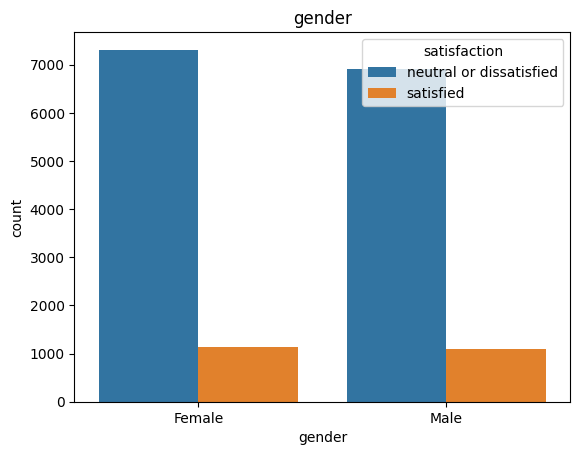

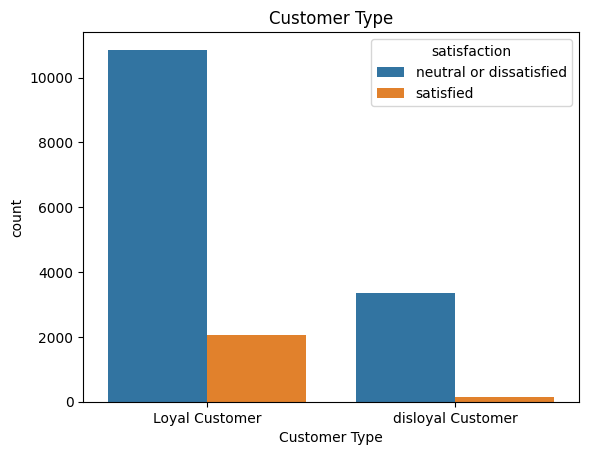

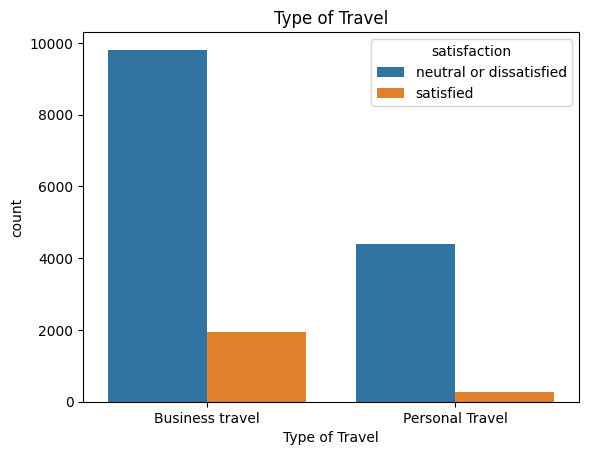

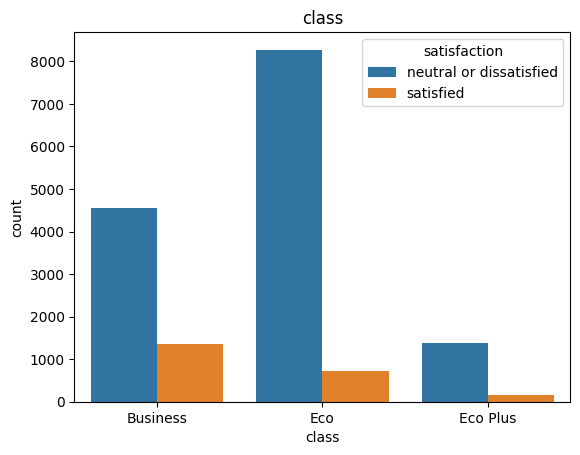

In [40]:
plot_categorical(categorical_cols, X_train, y_train)

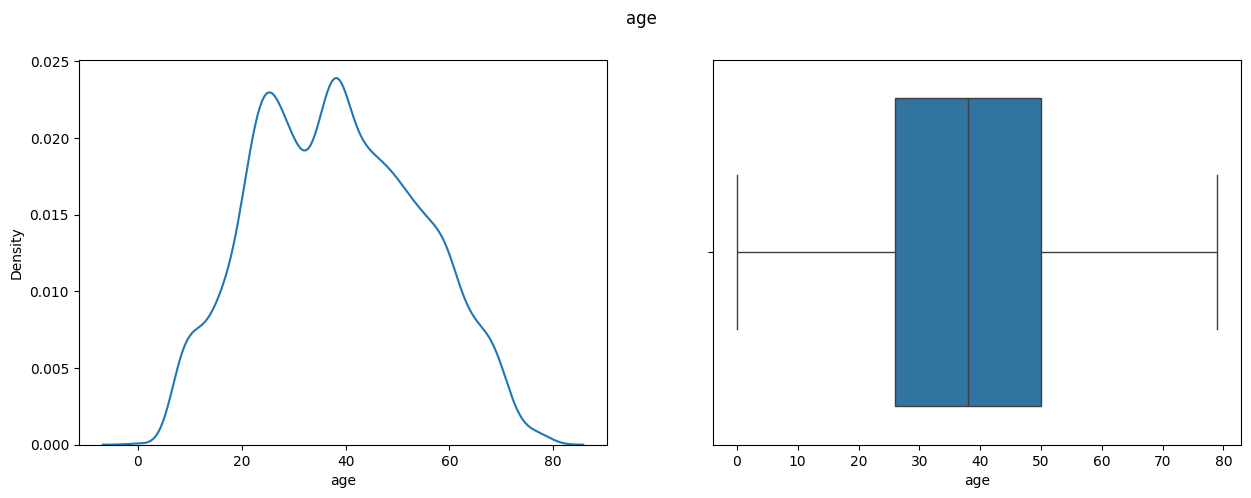

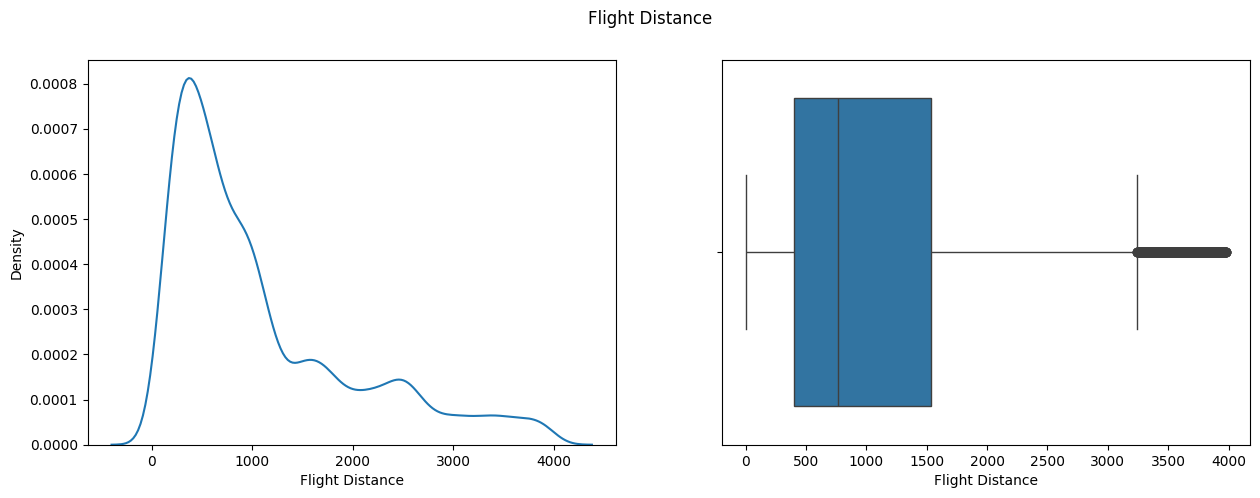

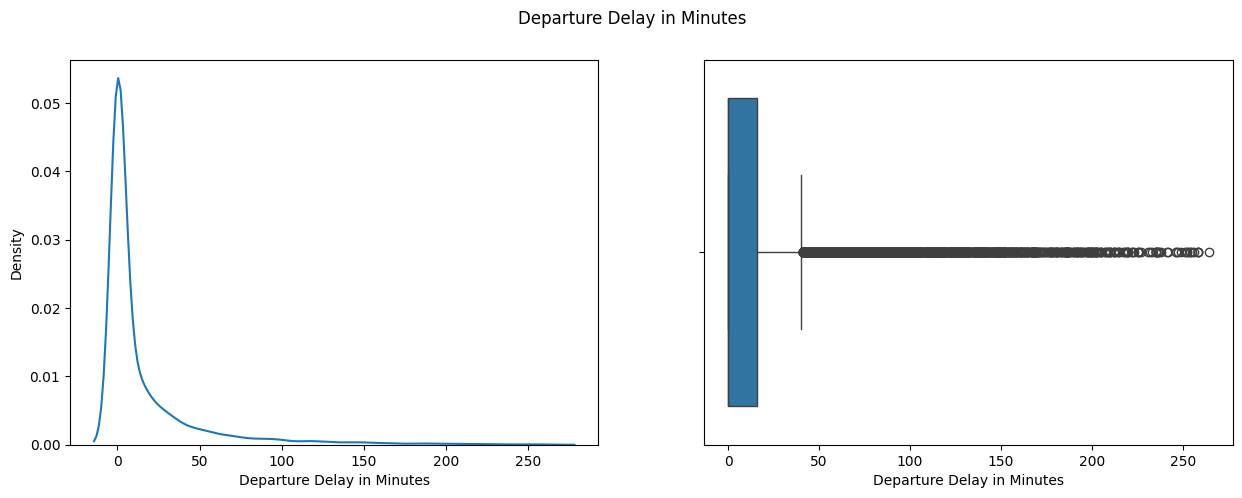

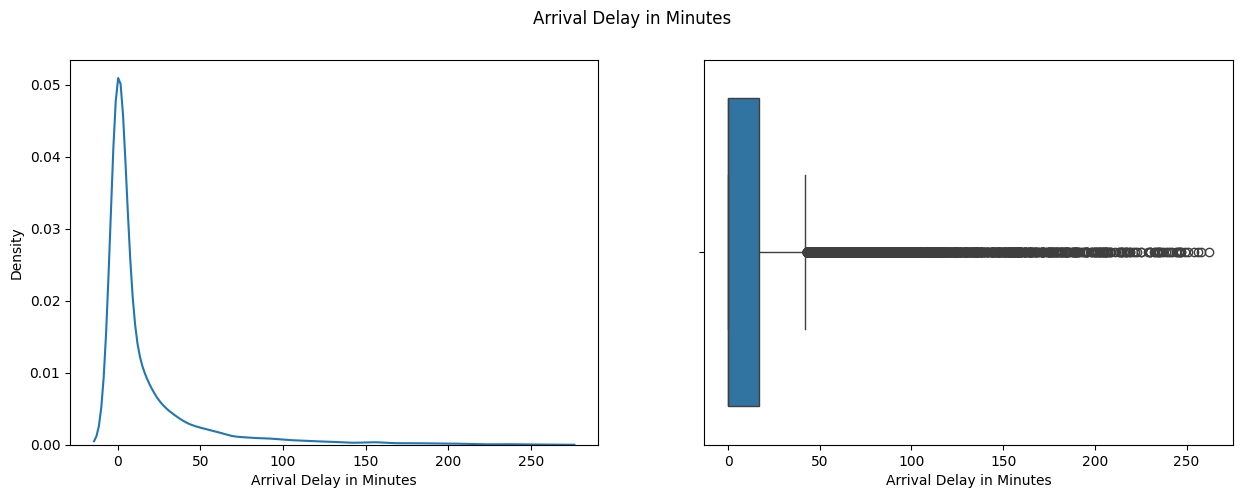

In [41]:
plot_continuous(continuous_cols, X_train, y_train)

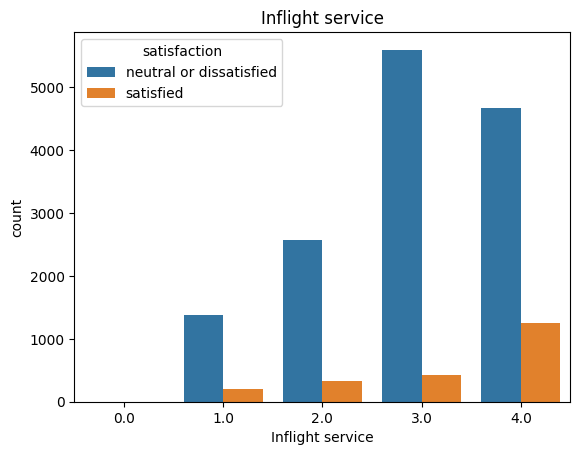

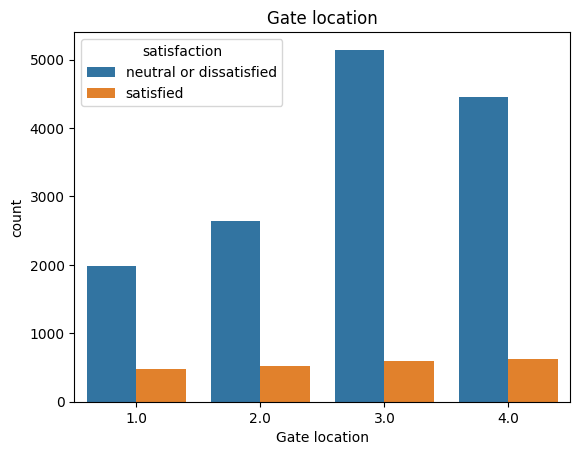

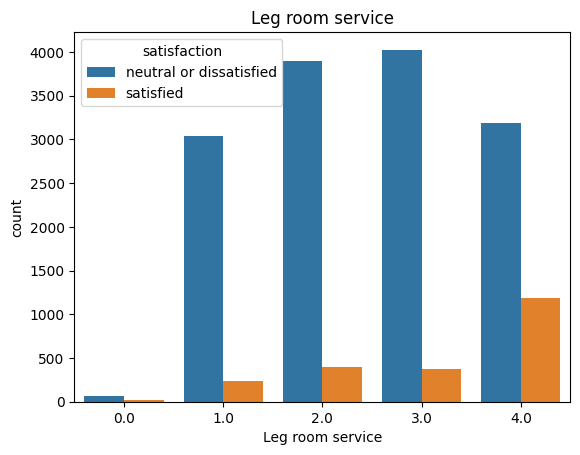

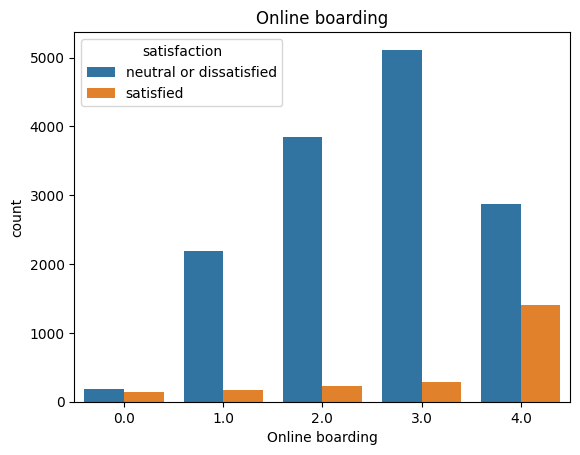

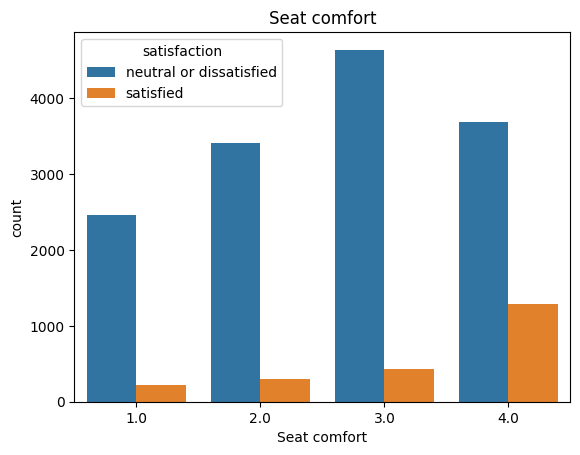

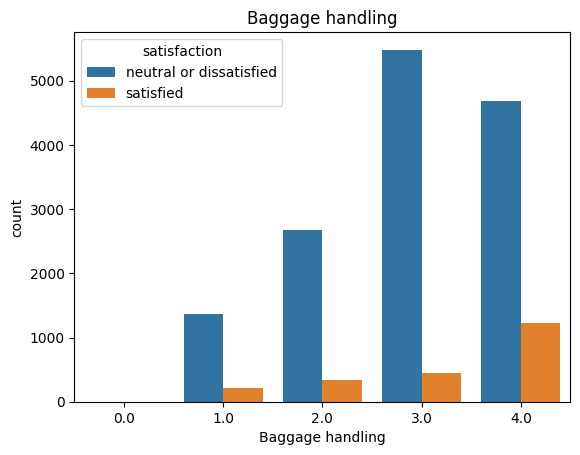

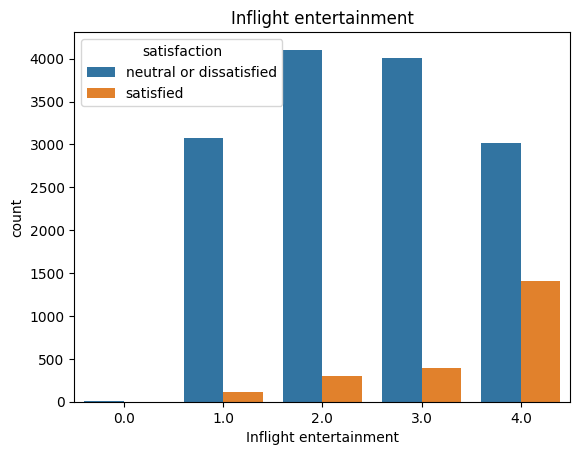

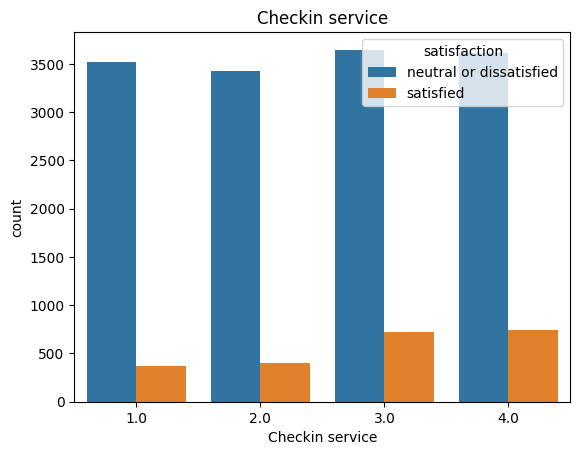

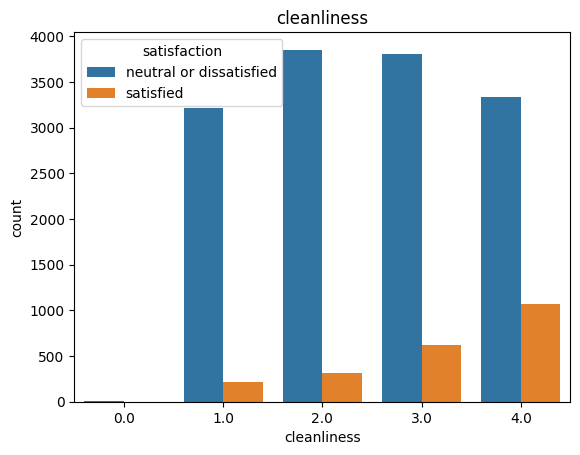

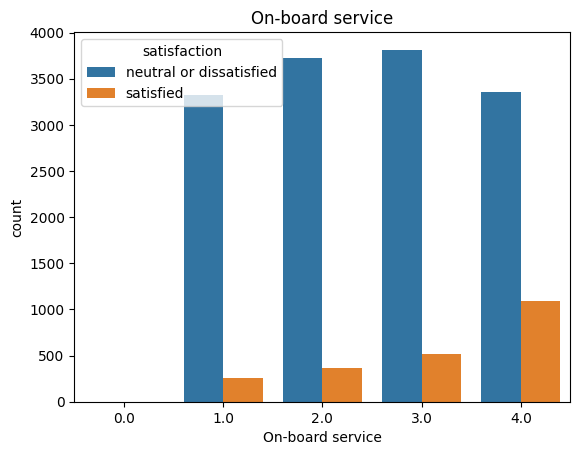

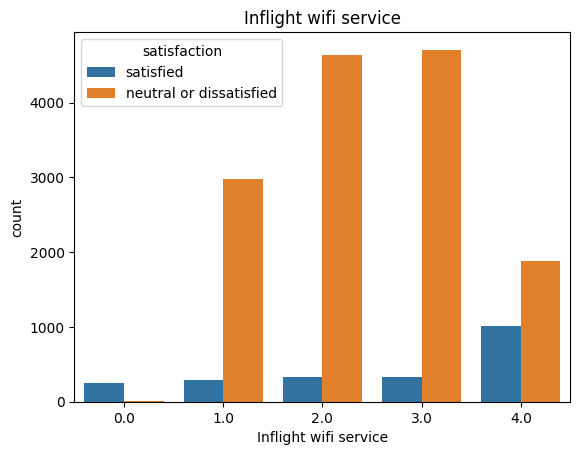

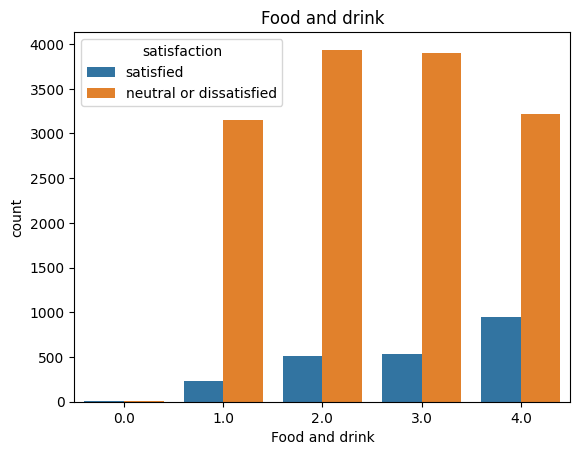

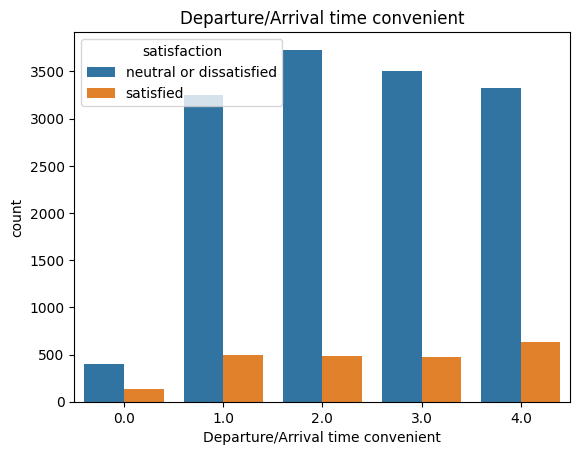

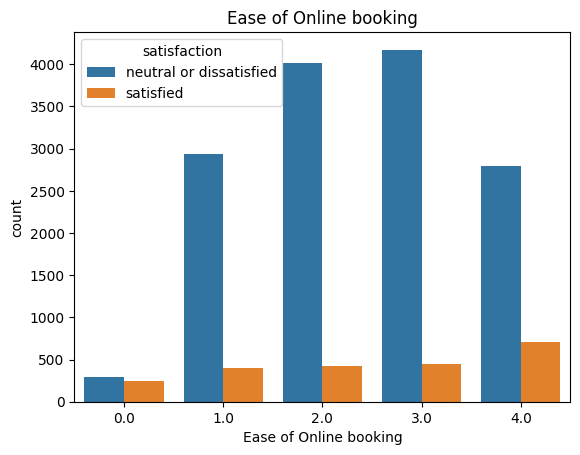

In [42]:
plot_ordinal(ordinal_cols, X_train, y_train)

<Axes: xlabel='count', ylabel='satisfaction'>

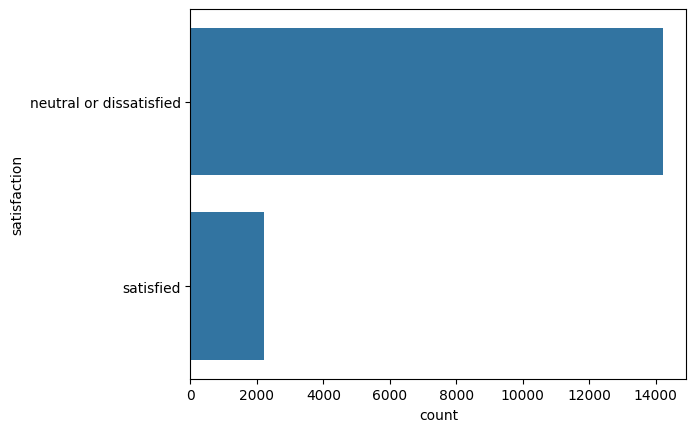

In [43]:
sns.countplot(data = y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Ваш ответ здесь
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [44]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [45]:
from math import log

In [46]:
df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].apply(lambda x: log(x) if x > 0 else x)
X_train['Departure Delay in Minutes'] = X_train['Departure Delay in Minutes'].apply(lambda x: log(x) if x > 0 else x)
X_val['Departure Delay in Minutes'] = X_val['Departure Delay in Minutes'].apply(lambda x: log(x) if x > 0 else x)

In [47]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].apply(lambda x: log(x) if x > 0 else x)
X_train['Arrival Delay in Minutes'] = X_train['Arrival Delay in Minutes'].apply(lambda x: log(x) if x > 0 else x)
X_val['Arrival Delay in Minutes'] = X_val['Arrival Delay in Minutes'].apply(lambda x: log(x) if x > 0 else x)

Построение.

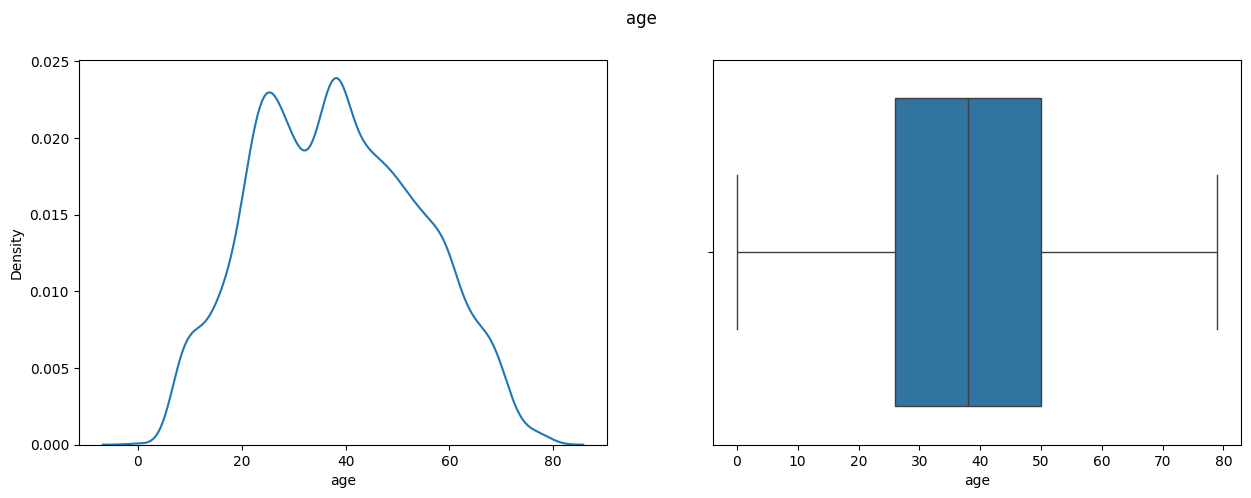

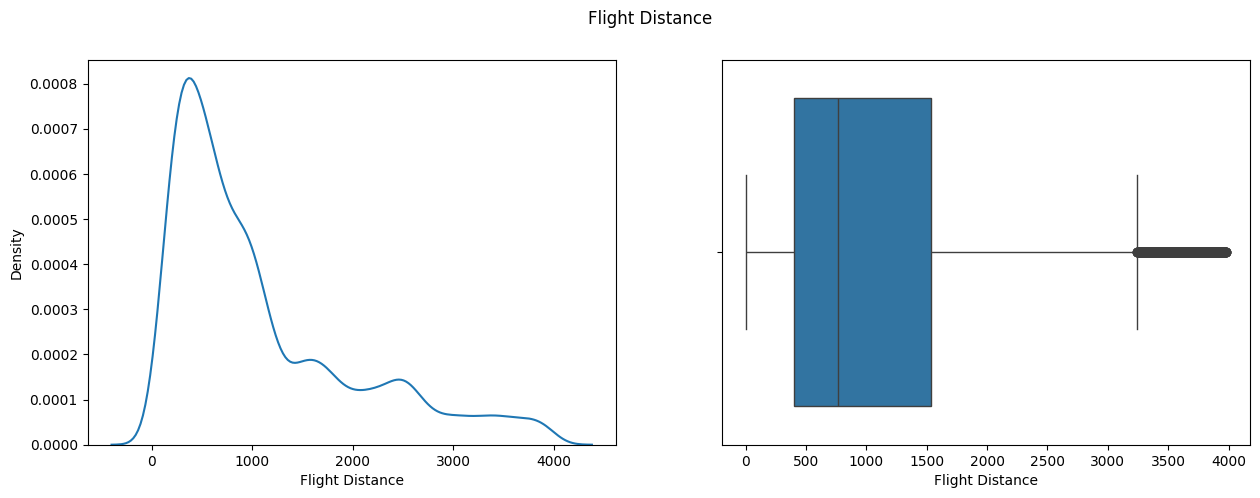

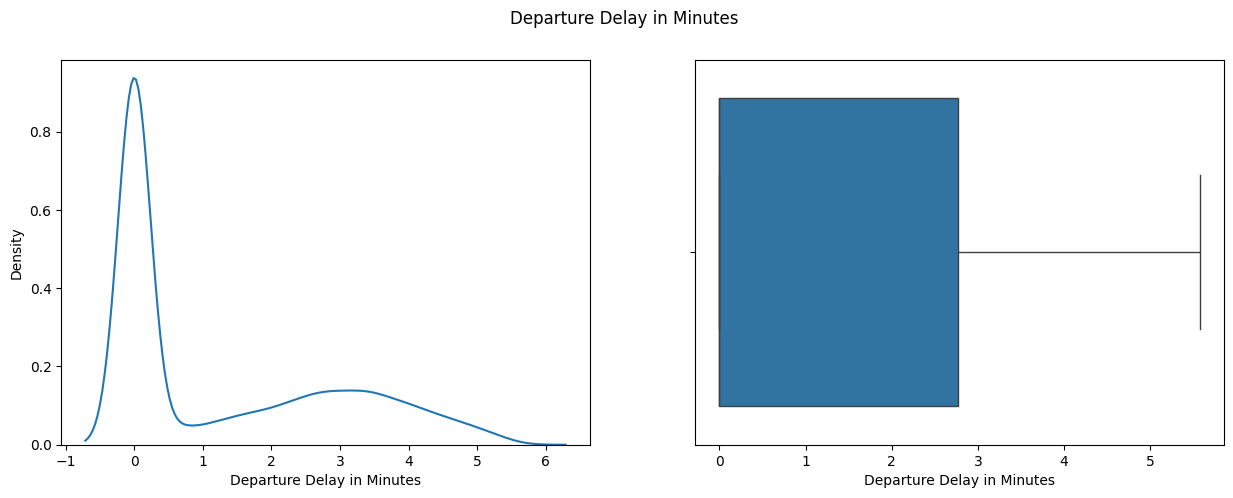

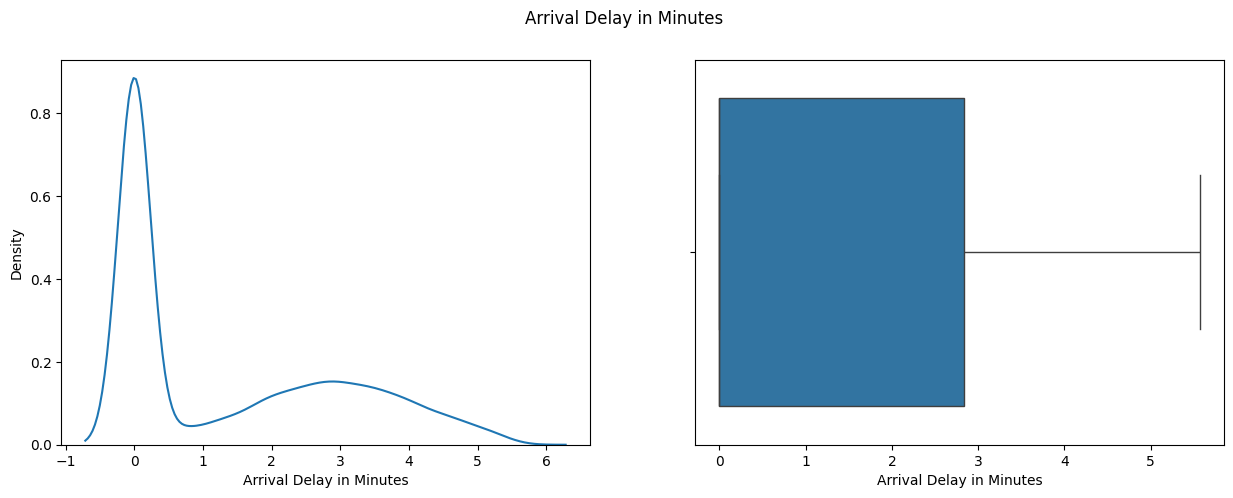

In [48]:
plot_continuous(continuous_cols, X_train, y_train)

Графики Departure Delay in Minutes и Arrival Delay in Minutes стали более вытянутые и более читабельные. До этого графики были резкими и угловатыми.

В boxplot пропали точки с выбросами, усы стали длинее.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [49]:
# Ваш код ниже

In [50]:
X_t = X_train.copy()
X_t['satisfaction'] = y_train

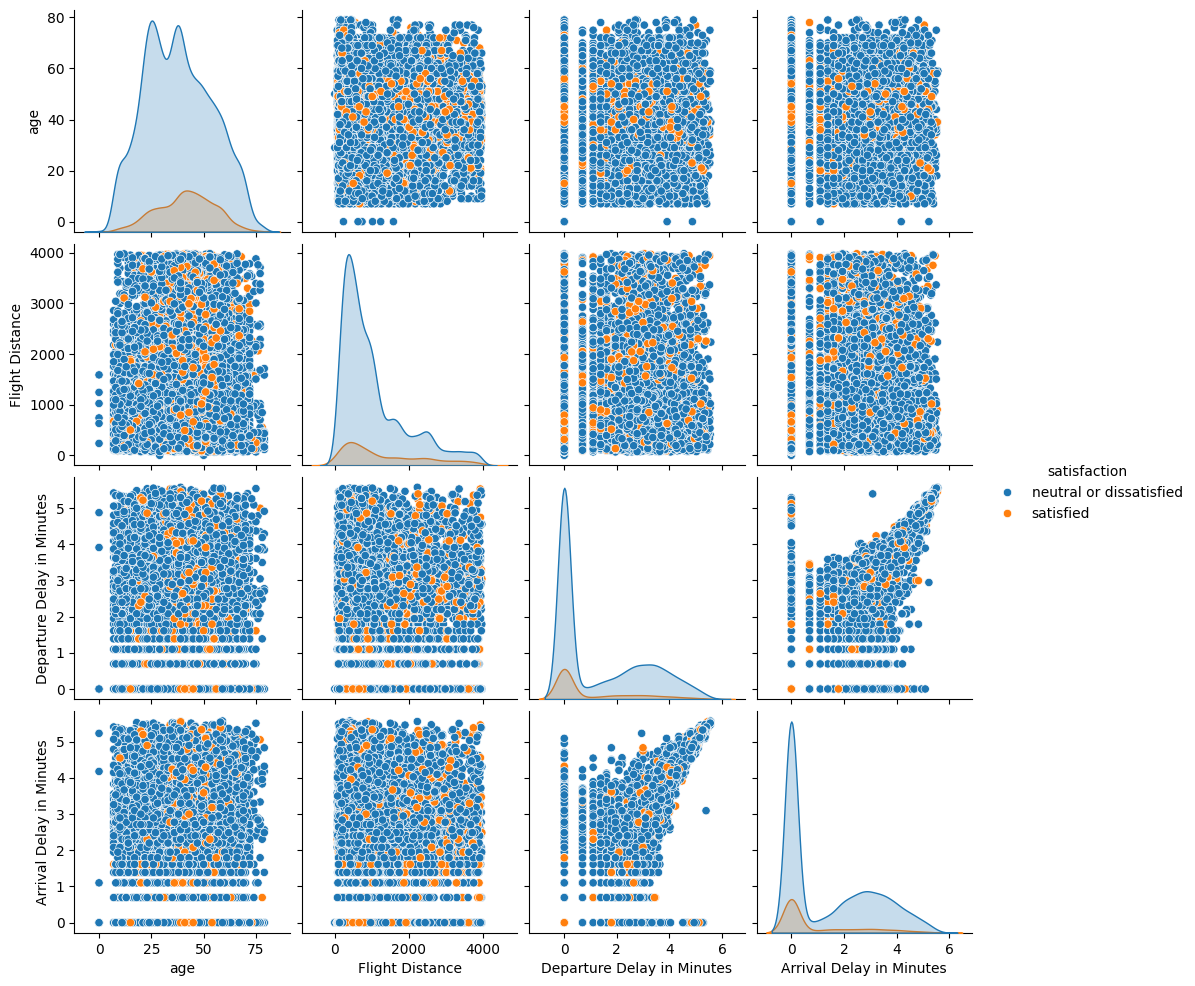

In [51]:
sns.pairplot(X_t, vars = continuous_cols, hue = 'satisfaction')

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [52]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [54]:
ohe = OneHotEncoder(sparse_output=False)

one_hot_encoded = ohe.fit_transform(X_train[categorical_cols]) #https://www.geeksforgeeks.org/ml-one-hot-encoding/
ohe_df_train = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(categorical_cols), index = X_train.index)
X_train_encoded = pd.concat([X_train, ohe_df_train], axis=1)
X_train_encoded = X_train_encoded.drop(categorical_cols, axis=1)

one_hot_encoded = ohe.fit_transform(X_val[categorical_cols])
ohe_df_val = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out(categorical_cols), index = X_val.index)
X_val_encoded = pd.concat([X_val, ohe_df_val], axis=1)
X_val_encoded = X_val_encoded.drop(categorical_cols, axis=1)

In [55]:
X_train_encoded.head()

age  Flight Distance  Departure Delay in Minutes  \
id                                                         
18121  56.0            120.0                    2.833213   
85525  64.0            259.0                    0.000000   
52581  56.0            160.0                    1.609438   
18566  23.0            190.0                    5.062595   
92191  19.0           1979.0                    0.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
id                                                       
18121                  1.098612                    1.0   
85525                  1.386294                    2.0   
52581                  0.000000                    3.0   
18566                  5.049856                    1.0   
92191                  0.000000                    3.0   

       Departure/Arrival time convenient  Ease of Online booking  \
id                                                                 
18121                                1.0                     4.0   
85525                                2.0                     2.0   
52581                                3.0                     3.0   
18566                                1.0                     1.0   
92191                                4.0                     4.0   

       Gate location  Food and drink  Online boarding  Seat comfort  \
id                                                                    
18121            1.0             3.0              4.0           3.0   
85525            3.0             4.0              2.0           4.0   
52581            3.0             2.0              2.0           4.0   
18566            1.0             2.0              1.0           2.0   
92191            4.0             3.0              4.0           3.0   

       Inflight entertainment  On-board service  Leg room service  \
id                                                                  
18121                     2.0               2.0               2.0   
85525                     4.0               4.0               1.0   
52581                     4.0               4.0               4.0   
18566                     4.0               2.0               3.0   
92191                     3.0               2.0               4.0   

       Baggage handling  Checkin service  Inflight service  cleanliness  \
id                                                                        
18121               1.0              3.0               2.0          4.0   
85525               4.0              4.0               4.0          4.0   
52581               3.0              4.0               4.0          2.0   
18566               3.0              2.0               1.0          2.0   
92191               3.0              3.0               3.0          3.0   

       gender_Female  gender_Male  Customer Type_Loyal Customer  \
id                                                                
18121            1.0          0.0                           1.0   
85525            0.0          1.0                           0.0   
52581            1.0          0.0                           1.0   
18566            1.0          0.0                           1.0   
92191            0.0          1.0                           1.0   

       Customer Type_disloyal Customer  Type of Travel_Business travel  \
id                                                                       
18121                              0.0                             1.0   
85525                              1.0                             1.0   
52581                              0.0                             1.0   
18566                              0.0                             1.0   
92191                              0.0                             1.0   

       Type of Travel_Personal Travel  class_Business  class_Eco  \
id                                                                 
18121                             0.0             1.0        0.0   
85

In [56]:
X_val_encoded.head()

age  Flight Distance  Departure Delay in Minutes  \
id                                                          
62191   55.0           1065.0                    0.000000   
128411  23.0            370.0                    3.951244   
43462   36.0            524.0                    3.891820   
84611   46.0            669.0                    4.094345   
56099   42.0           2402.0                    3.258097   

        Arrival Delay in Minutes  Inflight wifi service  \
id                                                        
62191                   0.000000                    3.0   
128411                  3.850148                    2.0   
43462                   4.553877                    3.0   
84611                   3.784190                    4.0   
56099                   3.135494                    3.0   

        Departure/Arrival time convenient  Ease of Online booking  \
id                                                                  
62191                                 3.0                     3.0   
128411                                1.0                     2.0   
43462                                 0.0                     4.0   
84611                                 3.0                     3.0   
56099                                 3.0                     3.0   

        Gate location  Food and drink  Online boarding  Seat comfort  \
id                                                                     
62191             3.0             1.0              4.0           1.0   
128411            3.0             2.0              2.0           2.0   
43462             3.0             3.0              4.0           3.0   
84611             3.0             2.0              3.0           4.0   
56099             3.0             4.0              4.0           4.0   

        Inflight entertainment  On-board service  Leg room service  \
id                                                                   
62191                      4.0               4.0               4.0   
128411                     2.0               4.0               4.0   
43462                      3.0               1.0               1.0   
84611                      4.0               4.0               4.0   
56099                      4.0               2.0               4.0   

        Baggage handling  Checkin service  Inflight service  cleanliness  \
id                                                                         
62191                4.0              2.0               4.0          3.0   
128411               3.0              1.0               3.0          2.0   
43462                3.0              3.0               3.0          3.0   
84611                4.0              4.0               4.0          3.0   
56099                4.0              4.0               3.0          4.0   

        gender_Female  gender_Male  Customer Type_Loyal Customer  \
id                                                                 
62191             0.0          1.0                           1.0   
128411            0.0          1.0                           0.0   
43462             0.0          1.0                           0.0   
84611             0.0          1.0                           1.0   
56099             1.0          0.0                           1.0   

        Customer Type_disloyal Customer  Type of Travel_Business travel  \
id                                                                        
62191                               0.0                             1.0   
128411                              1.0                             1.0   
43462                               1.0                             1.0   
84611                               0.0                             1.0   
56099                               0.0                             1.0   

        Type of Travel_Personal Travel  class_Business  class_Eco  \
id                                                                  
62191        

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [57]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_val_encoded)

In [58]:
accuracy_score(y_val, y_pred)

0.920670081683511

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [59]:
X_tr = X_train_encoded.values
X_vl = X_val_encoded.values

In [60]:
# Ваш код ниже — дополните его
from mlxtend.evaluate import bias_variance_decomp

error_dt, bias_dt, var_dt = bias_variance_decomp(model, X_tr, y_train.values, X_vl, y_val.values, loss='0-1_loss', random_seed=42)
error_dt, bias_dt, var_dt

(0.08260764225391112, 0.05427107849923855, 0.059397064931468915)

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

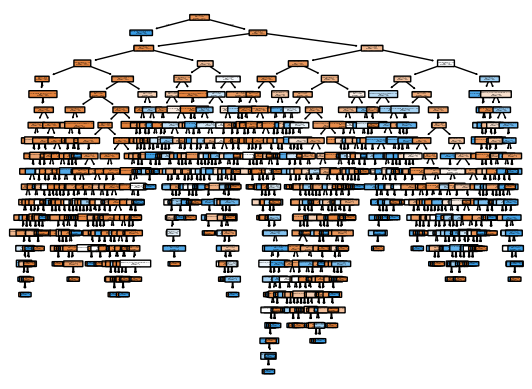

In [61]:
plot_tree(model, feature_names=X_train_encoded.columns, filled=True, rounded=True)
plt.show()

In [62]:
# Глубина
model.get_depth()

23

In [63]:
model.get_n_leaves()

610

У дерева глубина = 23, кол-во листьев = 610.

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

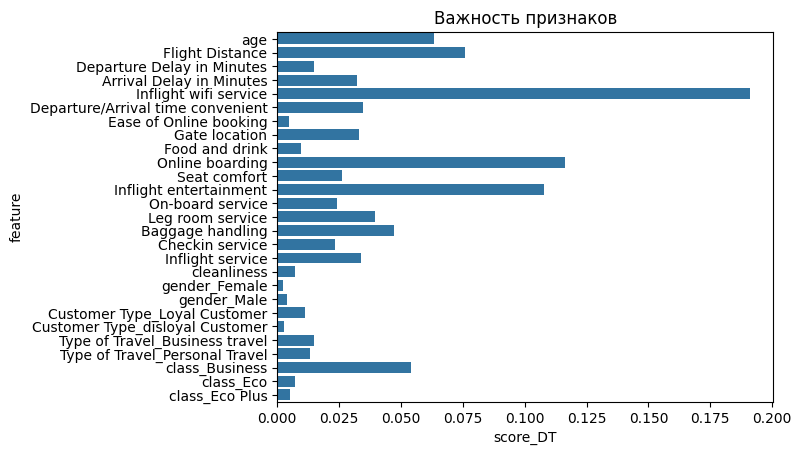

In [64]:
features = model.feature_importances_
df_features = pd.DataFrame({'Feature': X_train_encoded.columns, 'Importance': features})
sns.barplot(x='Importance', y='Feature', data=df_features)
plt.title('Важность признаков')
plt.xlabel('score_DT')
plt.ylabel('feature')
plt.show()

Наиболее информацтивными оказались Inflight wifi service, Online boarding,  Inflight entertainment.

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [65]:
model_1 = DecisionTreeClassifier(random_state=42, max_depth = 5)
model_1.fit(X_train_encoded[['Inflight wifi service', 'Online boarding']], y_train)
y_pred_1 = model_1.predict(X_val_encoded[['Inflight wifi service', 'Online boarding']])

In [66]:
accuracy_score(y_val, y_pred_1)

0.8795514329226083

Со всеми признаками было - 0.920670081683511, но дерево строилось намного дольше, чем с 2мя.

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [67]:
import graphviz
from sklearn import tree

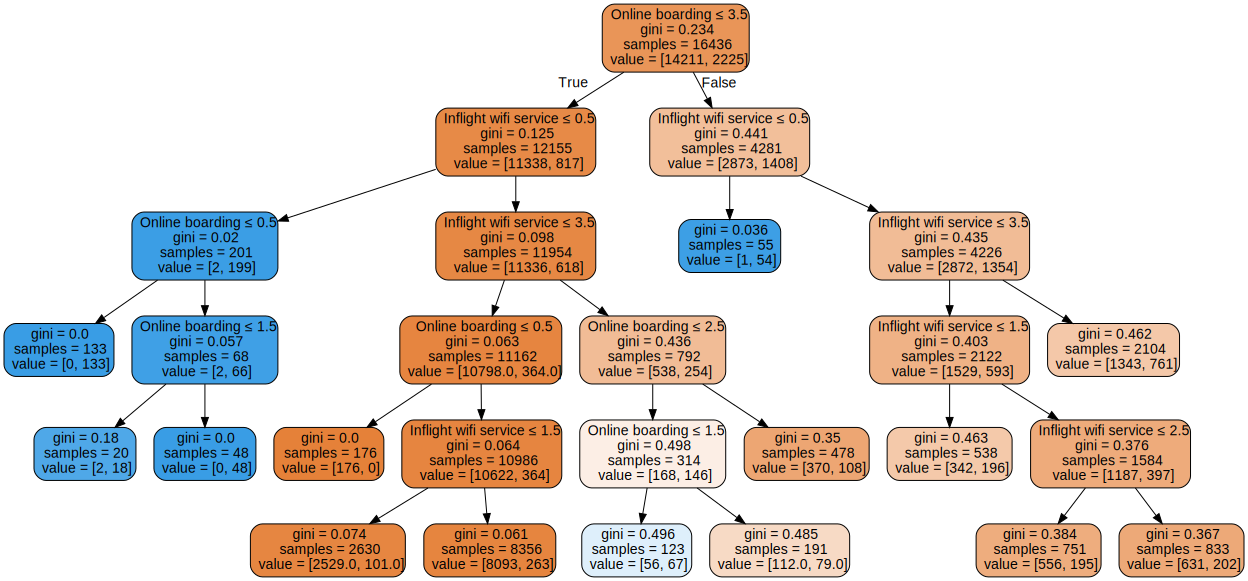

In [68]:
dot_data = tree.export_graphviz(model_1,  #https://stackoverflow.com/questions/42621190/display-this-decision-tree-with-graphviz
                  feature_names=['Inflight wifi service', 'Online boarding'],
                  filled=True, rounded=True,
                  special_characters=True,
                   out_file=None)
graph = graphviz.Source(dot_data)
graph

Предикаты не целые, а кратные 1/2, для того чтобы разделить данные для дальнейшей работы сними.

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

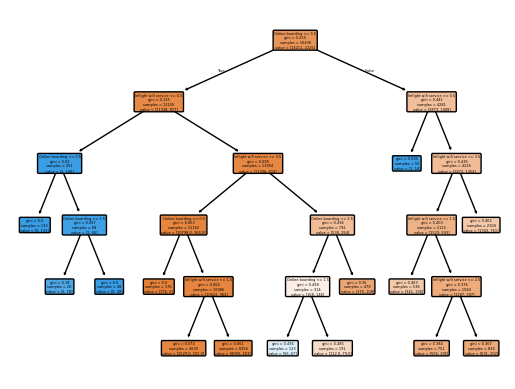

In [69]:
plot_tree(model_1, feature_names=['Inflight wifi service', 'Online boarding'], filled=True, rounded=True)
plt.show()


Дерево получилось не симметричным. В данном случае, мы ограничили глубину, поэтому дерево не должно быть переобученным, но мы все равно может с этим встретиться. И отсутствие симметричности может подсказать нам об этом.

Также получается, что дерево хорошо и эффективно использует одну свою сторону, а вторую не очень.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

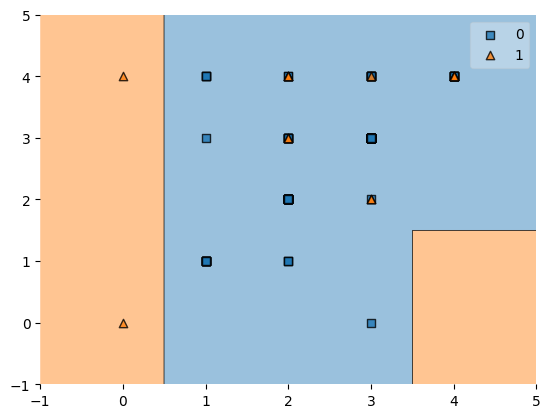

In [70]:
plot_decision_regions(X_train_encoded[['Inflight wifi service', 'Online boarding']].head(100).values, y_train[:100].values, model_1)

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local

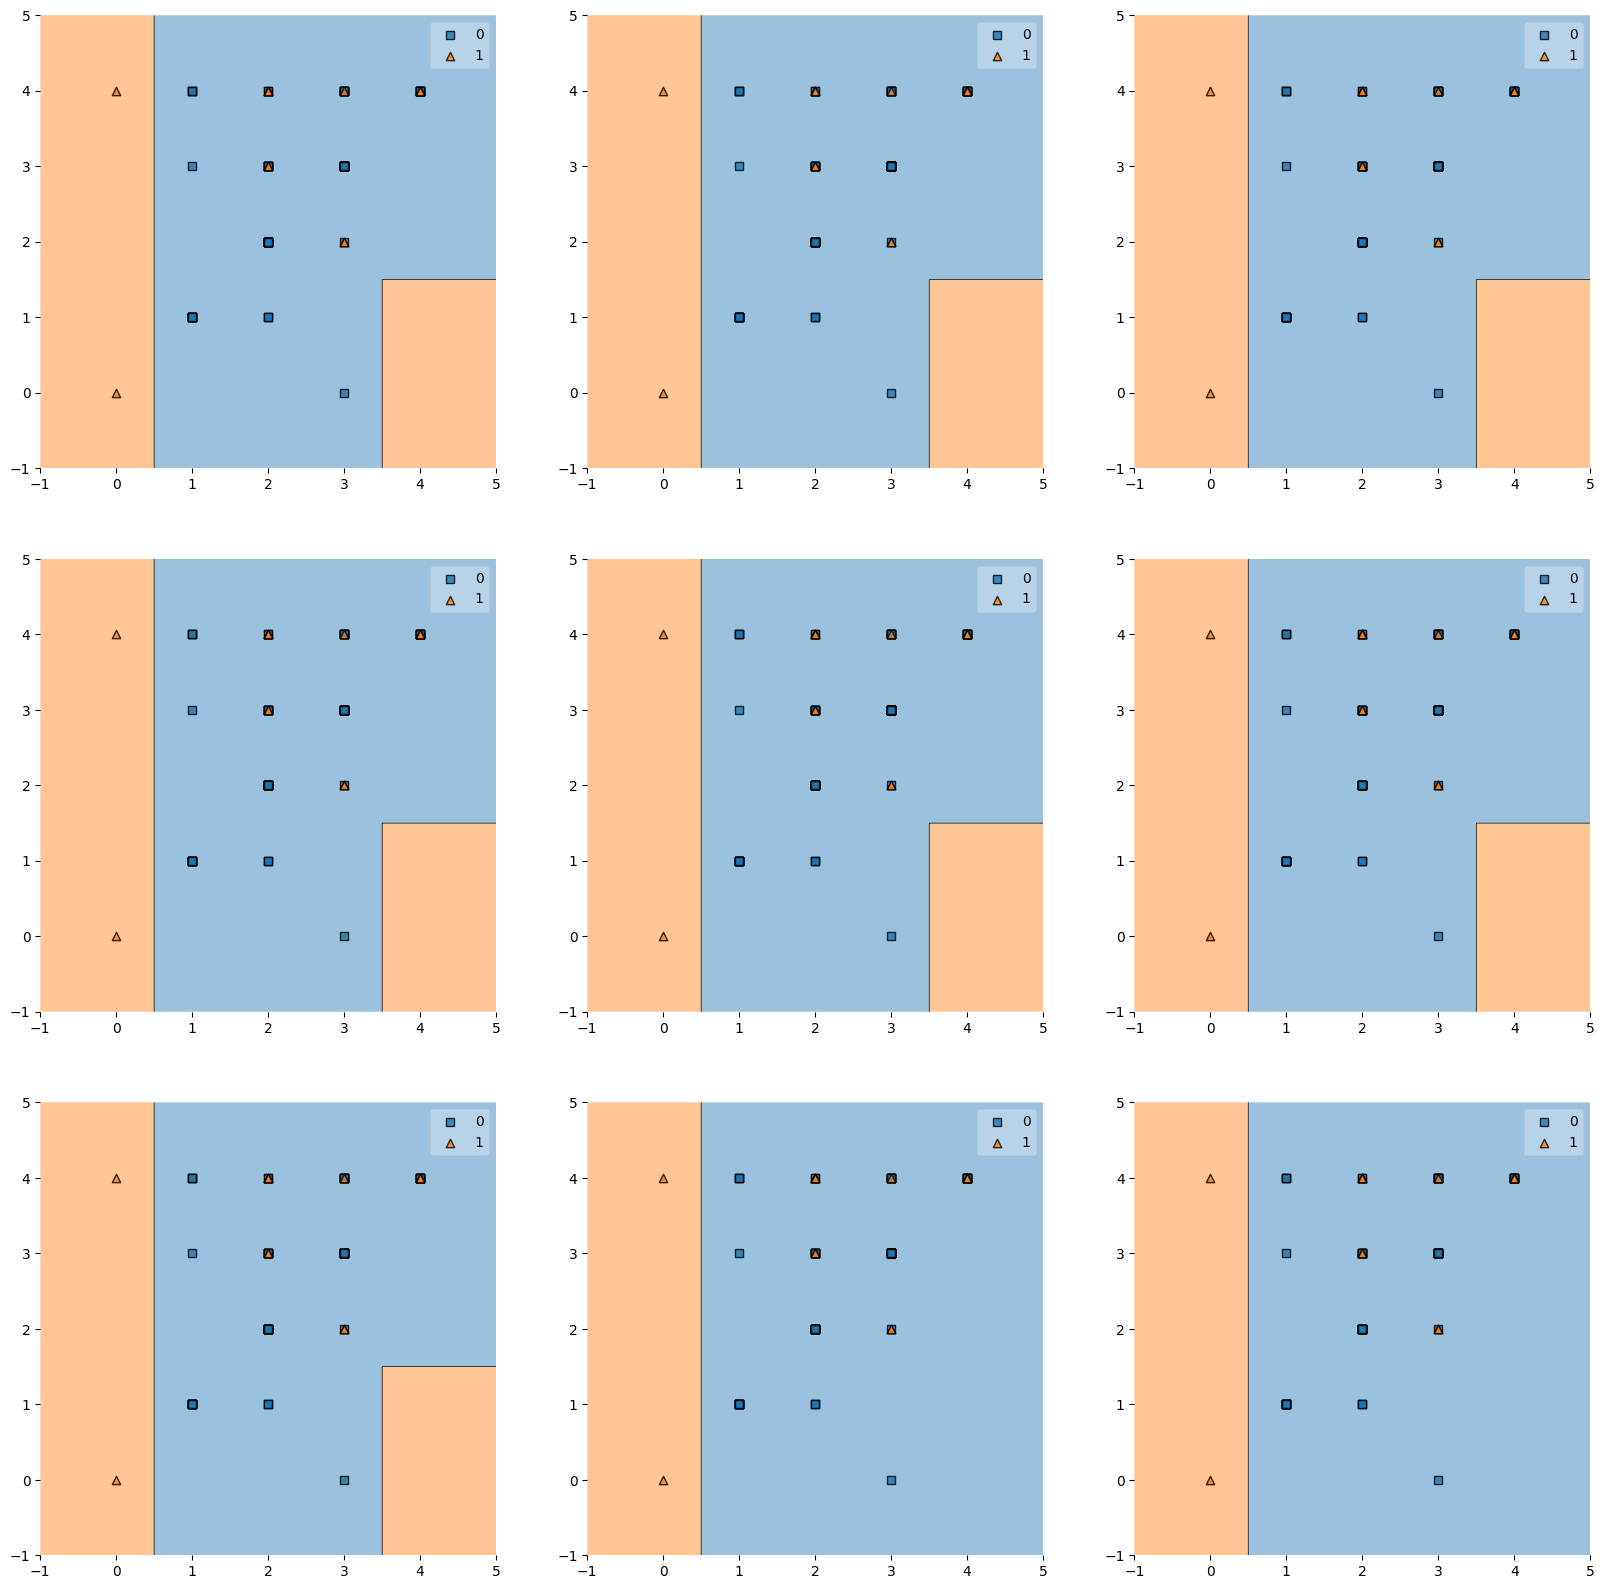

In [71]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_encoded[['Inflight wifi service', 'Online boarding']].index, size=X_train_encoded[['Inflight wifi service', 'Online boarding']].shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_encoded[['Inflight wifi service', 'Online boarding']].loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_encoded[['Inflight wifi service', 'Online boarding']].iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [72]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_encoded, y_train)
    y_predicted_train = DT.predict(X_train_encoded)
    y_predicted_val = DT.predict(X_val_encoded)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 927 ms, sys: 1.82 ms, total: 929 ms
Wall time: 927 ms


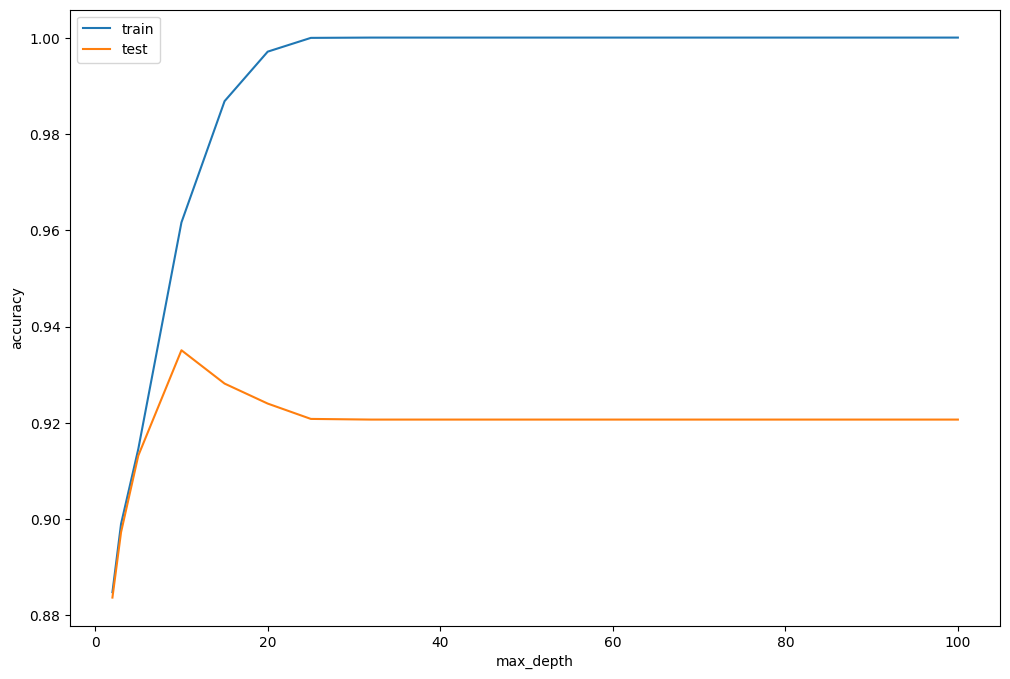

In [73]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [74]:
param_grid = {'max_depth': [3,5,7,10,15,20], 'min_samples_leaf': [1,2,4,8,10,15,20], 'min_samples_split': [2, 5, 10, 15, 20]}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)


In [75]:
grid_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20]})

In [76]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15}

In [77]:
best_model = grid_search.best_estimator_
pred = best_model.predict(X_val_encoded)
accuracy_score(y_val, pred)

0.9345147445659698

Качество без подбора параметров = 0.920670081683511

Качество модели после gridsearch = 0.9345147445659698

Качество модели улучшилось на 0.014

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [78]:
with open('DT.pkl', 'wb') as f:
  pickle.dump(best_model, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [79]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_encoded, y_train)

y_pred = rf.predict(X_val_encoded)

In [80]:
accuracy_score(y_val, y_pred)

0.9464211546448844

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [81]:
probs = rf.predict_proba(X_val_encoded)[:, 1]

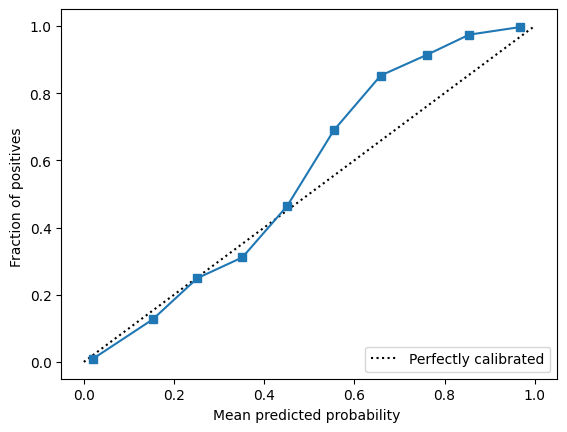

In [82]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
prob_true, prob_pred = calibration_curve(y_val, probs, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, probs)
disp.plot()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Ваш ответ здесь
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [83]:
clf = LogisticRegression(random_state=42)

param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [1, 2, 5, 10, 15, 20, 40, 100, 300, 500]}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid)

grid_search.fit(X_train_encoded, y_train)
grid_search.best_params_
best_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

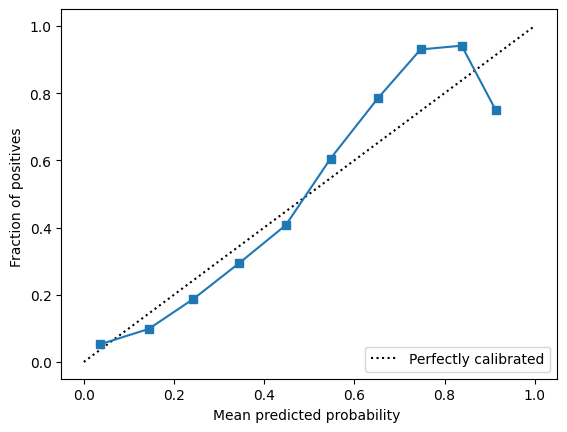

In [84]:
probs = best_model.predict_proba(X_val_encoded)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, probs, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, probs)
disp.plot()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ваш ответ здесь
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [85]:
from sklearn.calibration import CalibratedClassifierCV

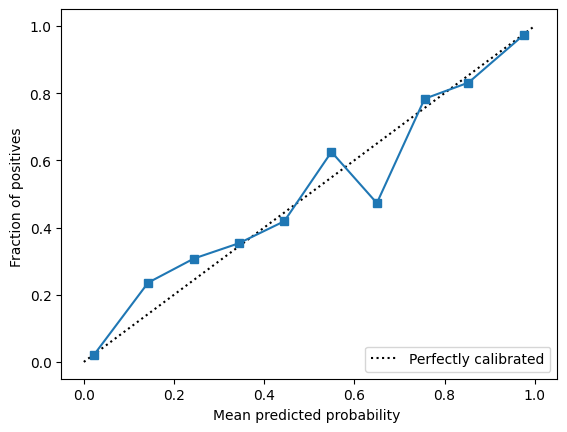

In [86]:
rf_regr = CalibratedClassifierCV(rf)
rf_regr.fit(X_train_encoded, y_train)

probs_calibr_regr = rf_regr.predict_proba(X_val_encoded)[:, 1]

prob_true, prob_pred = calibration_curve(y_val, probs_calibr_regr, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, probs_calibr_regr)
disp.plot()



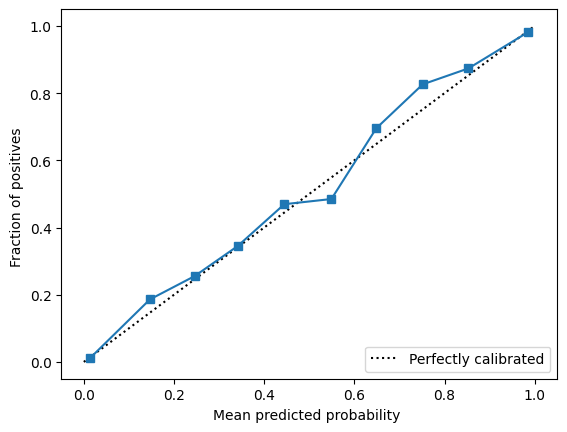

In [87]:
rf_isot = CalibratedClassifierCV(rf, method='isotonic')
rf_isot.fit(X_train_encoded, y_train)

probs_calibr_isot = rf_isot.predict_proba(X_val_encoded)[:, 1]

prob_true, prob_pred = calibration_curve(y_val, probs_calibr_isot, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, probs_calibr_isot)
disp.plot()


Калибровка с помощью изотонической регрессии получилась более лучше (калибровочная кривая намного ближе к идеальной).

Кривые стали лучше чем были у обоих методов.

У первой кривой (по сигмоиде) модель занижает вероятность у части объектов, а высокая вероятность наоборот слегка переоценена.

Во второй кривой большая часть вероятностей недооценена.

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Ваш ответ здесь
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [88]:
error_rf, bias_rf, var_rf = bias_variance_decomp(rf, X_tr, y_train.values, X_vl, y_val.values, loss='0-1_loss', random_seed=42)

In [89]:
error_dt

0.08260764225391112

In [90]:
print('Average expected loss:')
print('Дерево решений: ' + str(round(error_dt, 3)))
print('Случайный лес: ' + str(round(error_rf, 3)))

print('Average bias:')
print('Дерево решений: ' + str(round(bias_dt, 3)))
print('Случайный лес: ' + str(round(bias_rf, 3)))

print('Average variance:')
print('Дерево решений: ' + str(round(var_dt, 3)))
print('Случайный лес: ' + str(round(var_rf, 3)))

Average expected loss:
Дерево решений: 0.083
Случайный лес: 0.057
Average bias:
Дерево решений: 0.054
Случайный лес: 0.056
Average variance:
Дерево решений: 0.059
Случайный лес: 0.012


Разброс почти одинаковый у деревьев, а вот смещение у случайного леса намного меньше.

Второй вопрос не понимаю. Могу предположить, что соответствуют, но почему - не знаю.


### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [91]:
from sklearn.metrics import log_loss
probs = best_model.predict_proba(X_val_encoded)[:, 1]

ael = log_loss(y_val, probs)

In [92]:
ael

0.31140944871828435

Наибольшее разложение ошибки получилось у логистической регрессии, самое наименьшее у случайного леса.

Ошибка в линейной регрессии очень зависит от модели и от данных. На некоторых данные нельзя построить хорошую модель -> ошибка будет очень большой.

В решающем дереве предикаты формируются на основе данных, поэтому возможно построить достаточно точную модель (но она будет глубокой). Поэтому ошибка может быть маленькой.

Метод случайного леса использует несколько решающих деревьев, поэтому в методе еще меньше среднее значение разложения ошибки.



### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [93]:
# Ваш код здесь
from scipy.stats import uniform

In [94]:
distributions = dict(ccp_alpha=uniform(0, 5), min_samples_split = uniform(0, 1), max_depth=[0, 5, 10, 20])

In [95]:
rf_p = RandomizedSearchCV(rf, distributions, random_state=42)

In [96]:
search = rf_p.fit(X_train_encoded, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

In [97]:
pred = search.predict(X_val_encoded)

In [98]:
accuracy_score(y_val, pred)

0.862522497577184

Качество модели получилось хуже :(

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [99]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_encoded[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


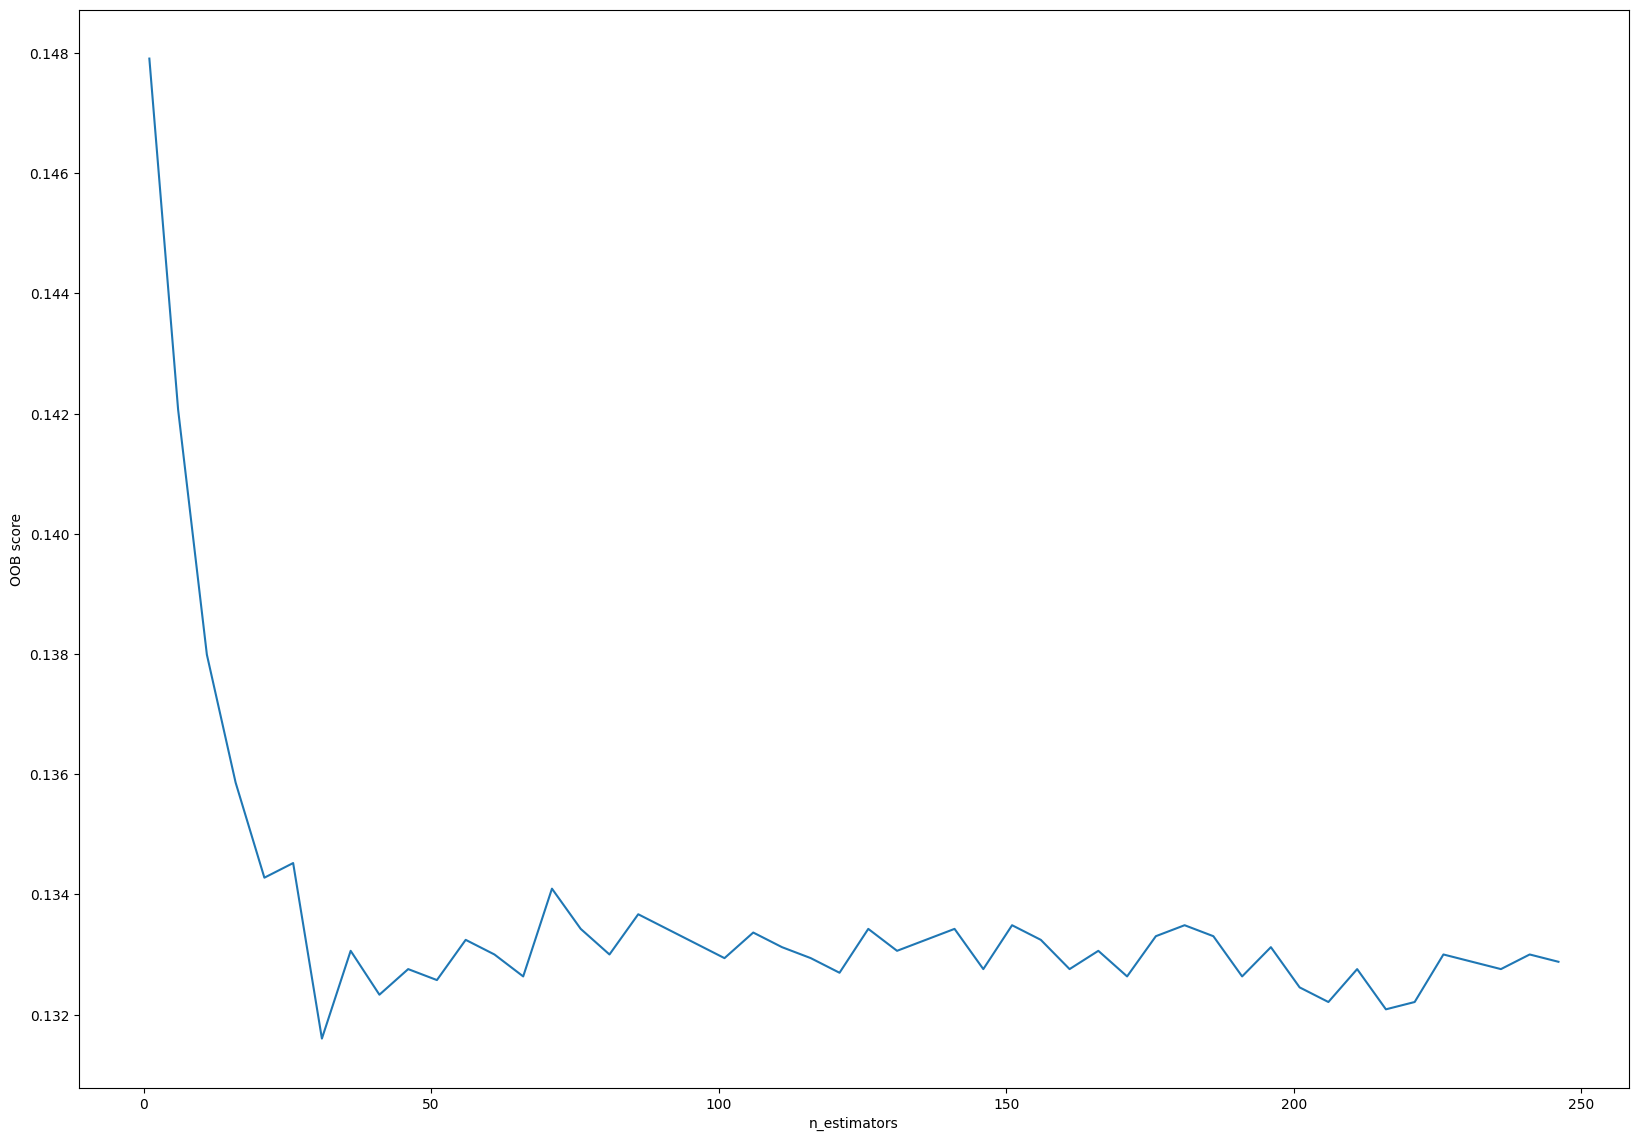

In [100]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [101]:
rf.feature_importances_

array([0.06557411, 0.06855097, 0.02754862, 0.03304235, 0.1558009 ,
       0.02940853, 0.03688958, 0.02890259, 0.02327098, 0.08328647,
       0.03802049, 0.05817023, 0.03266689, 0.04876396, 0.0360499 ,
       0.03474913, 0.03604851, 0.02793549, 0.00892245, 0.00824188,
       0.01355111, 0.01355692, 0.01589939, 0.01845423, 0.03097182,
       0.01999387, 0.00572862])

In [102]:
#best decision tree
with open('DT.pkl', 'rb') as f:
  loaded_model = pickle.load(f)

In [103]:
loaded_model.feature_importances_

array([0.02795263, 0.02021543, 0.00111573, 0.0107114 , 0.25917157,
       0.02900783, 0.00511868, 0.03101371, 0.00615222, 0.16430872,
       0.02090858, 0.14398518, 0.02512632, 0.05458211, 0.03433931,
       0.01826447, 0.02248964, 0.005544  , 0.00206449, 0.        ,
       0.01000126, 0.00325331, 0.00622043, 0.03547289, 0.06195223,
       0.00102785, 0.        ])

In [104]:
features = pd.DataFrame([rf.feature_importances_, loaded_model.feature_importances_], columns=X_train_encoded.columns, index=['RF', 'DT'])

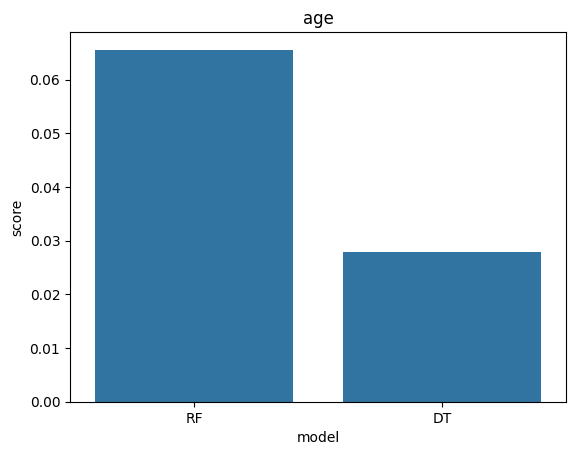

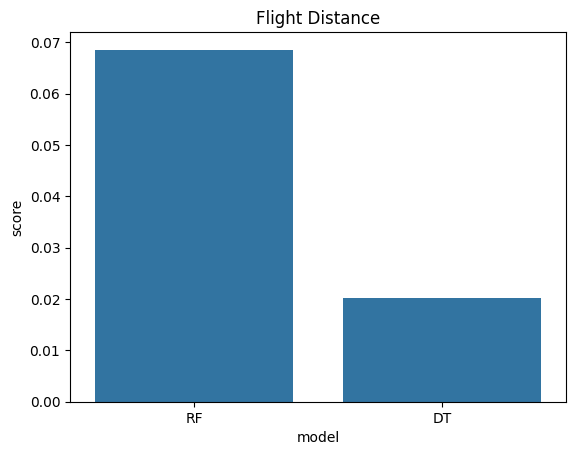

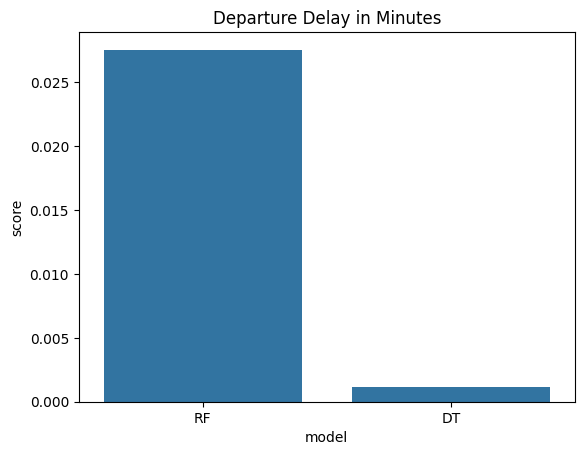

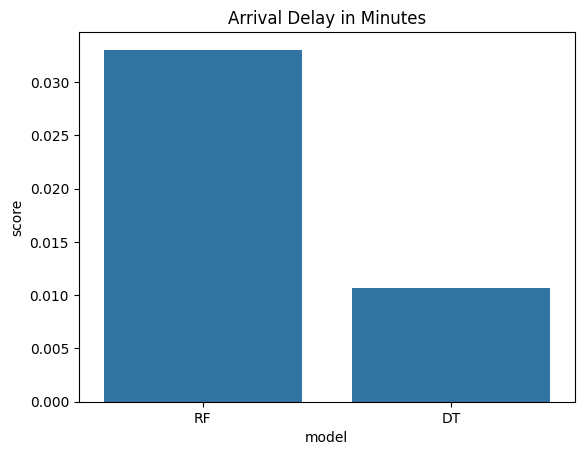

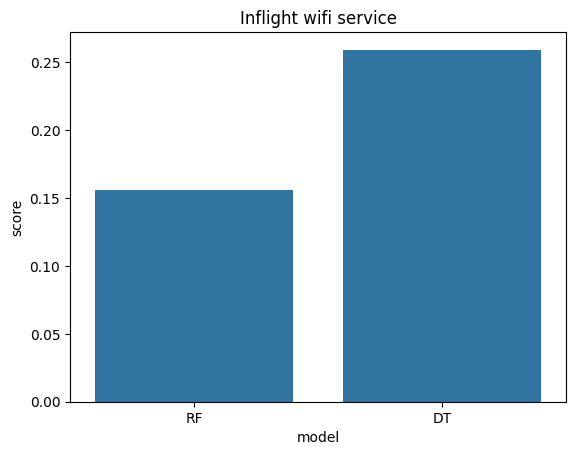

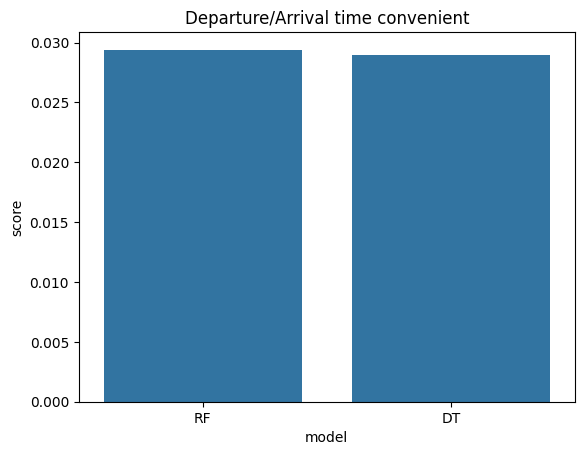

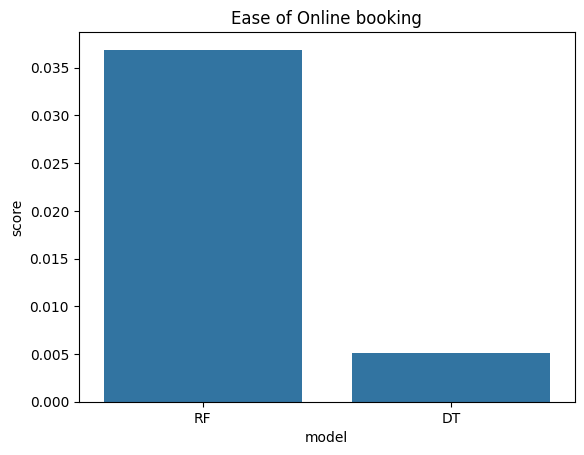

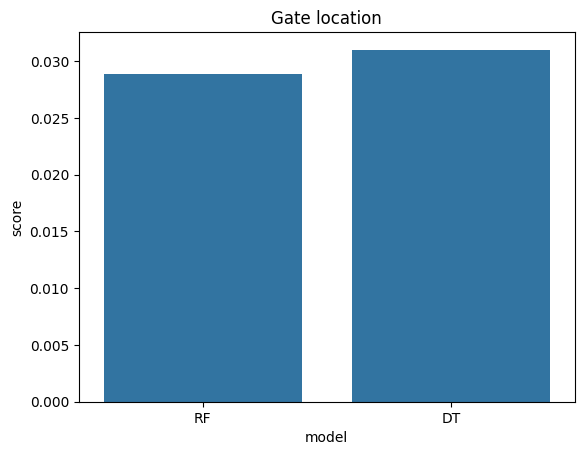

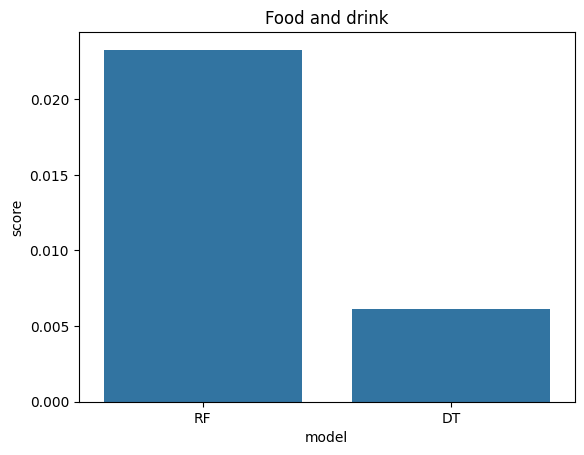

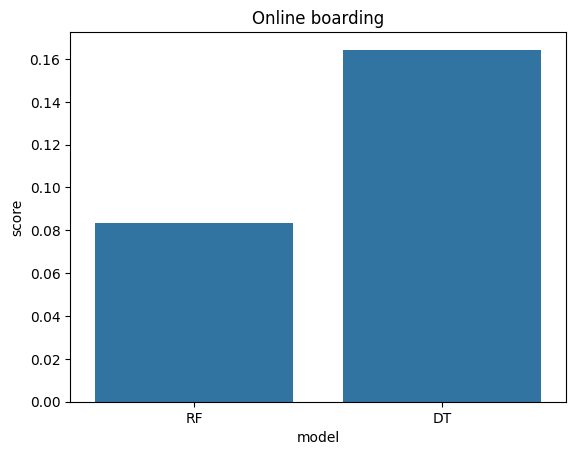

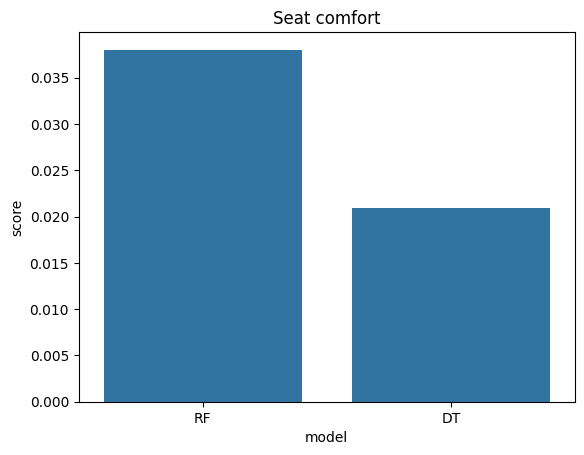

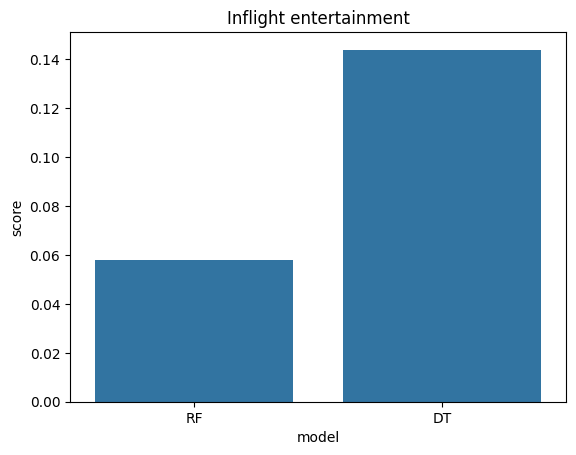

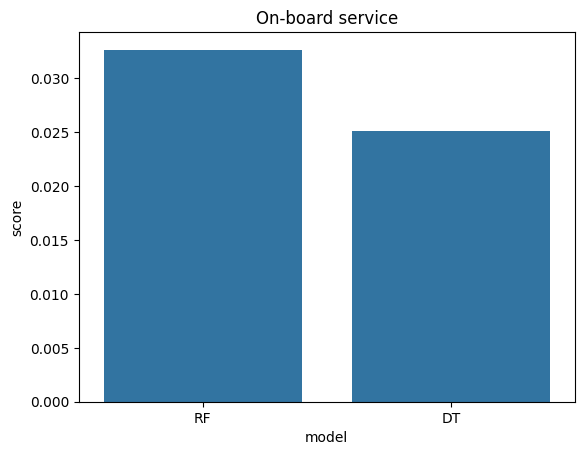

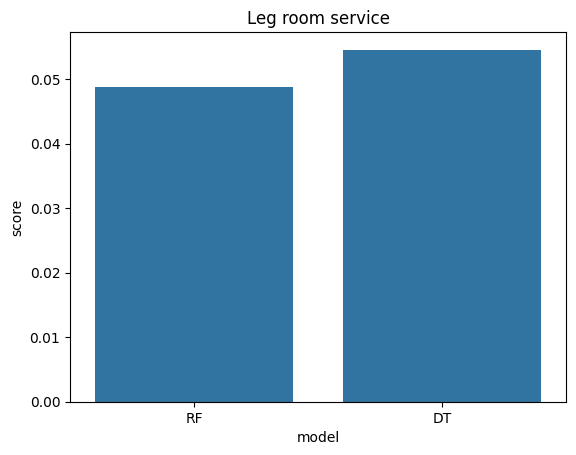

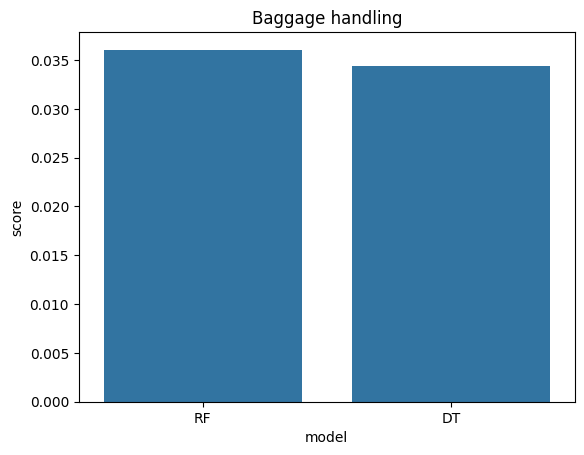

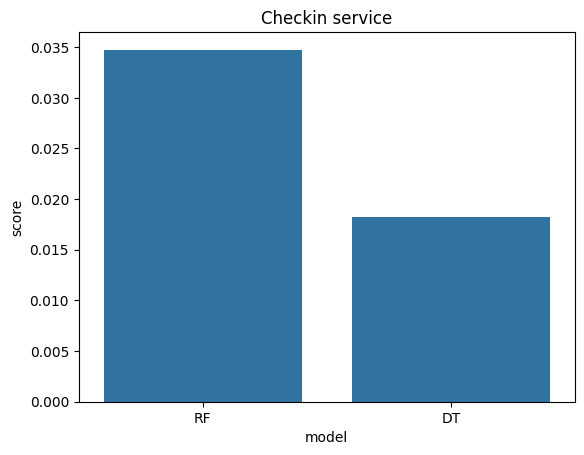

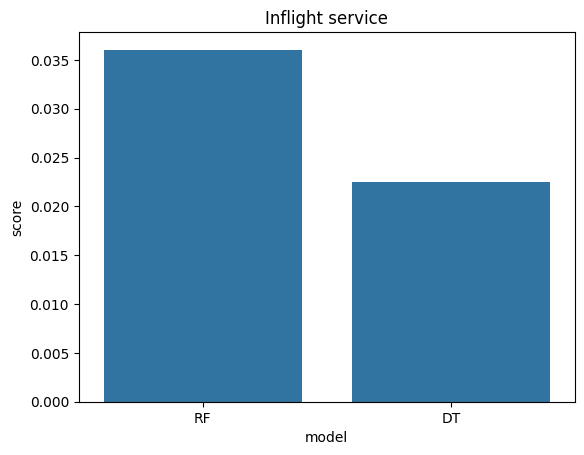

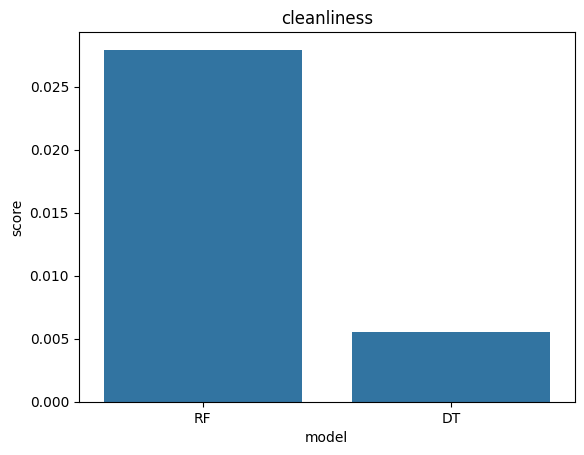

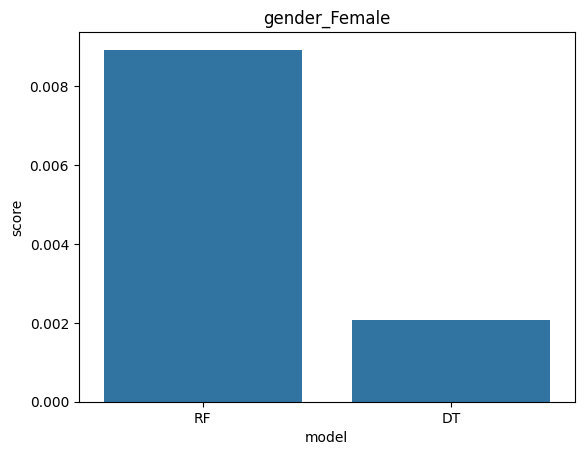

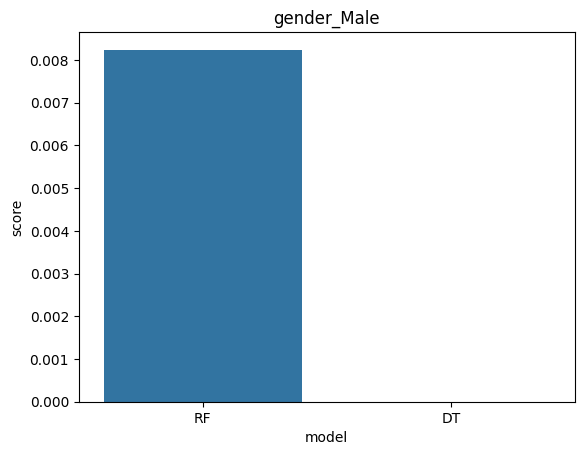

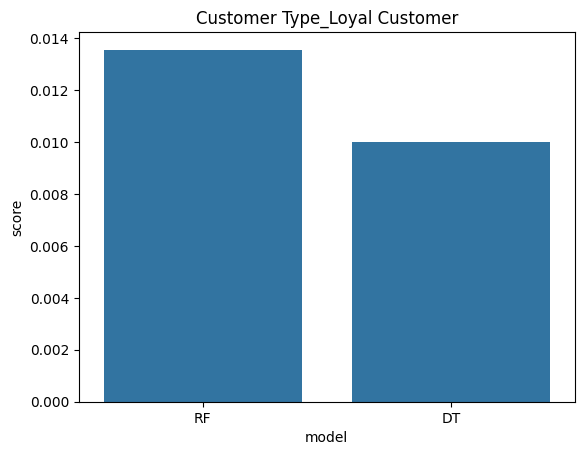

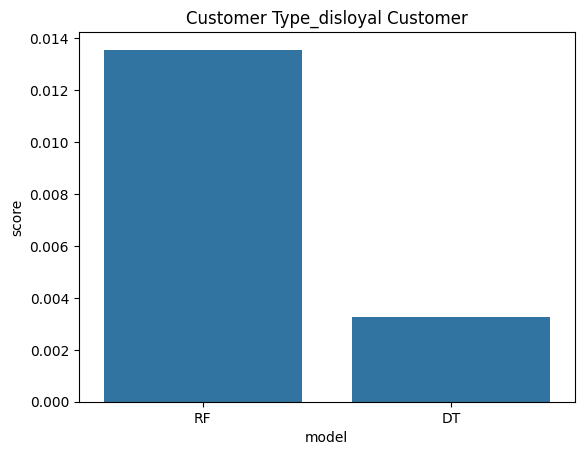

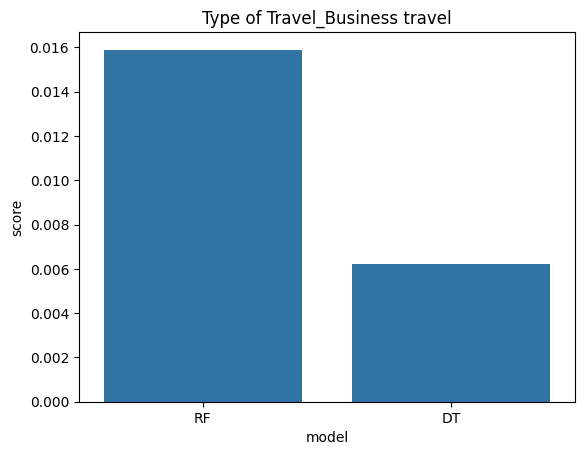

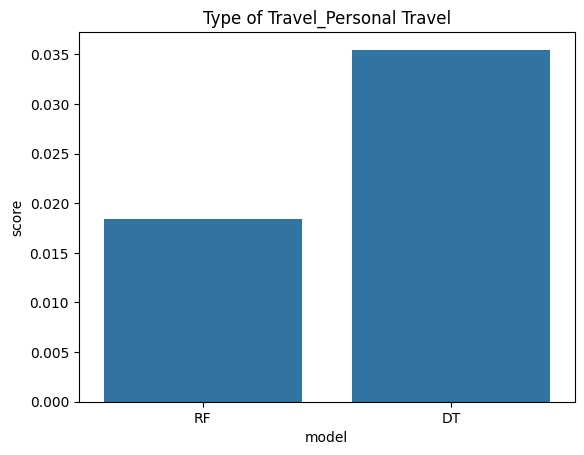

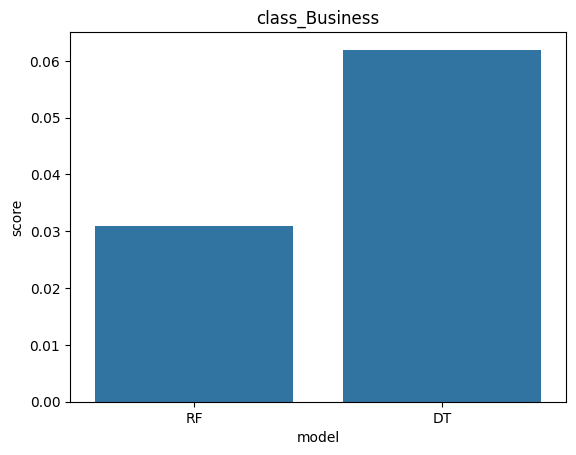

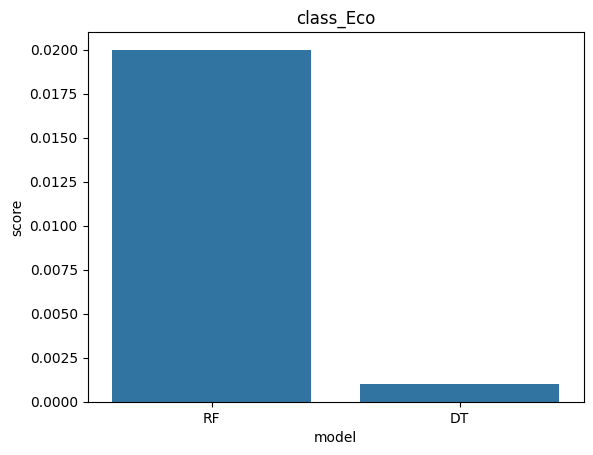

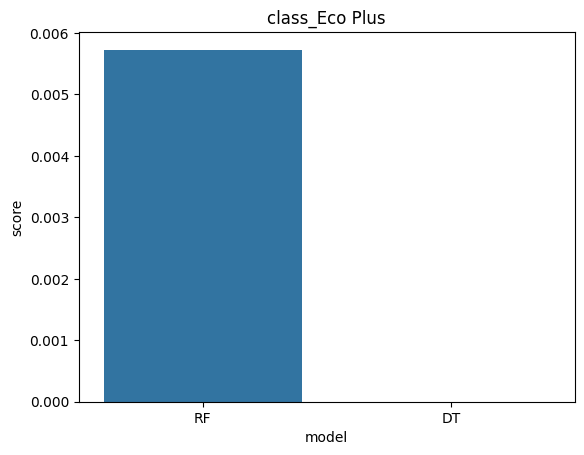

In [105]:
for c in X_train_encoded.columns:
  sns.barplot(x=features.index, y=features[c])
  plt.title(c)
  plt.xlabel('model')
  plt.ylabel('score')
  plt.show()


### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [106]:
with open('RF.pkl', 'wb') as f:
  pickle.dump(rf, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [125]:
# Ваш код здесь
explainer = shap.TreeExplainer(loaded_model)

In [126]:
vals = X_val_encoded.sample(1000)

In [127]:
explainer = shap.TreeExplainer(loaded_model)

In [128]:
shap_values = explainer.shap_values(vals)

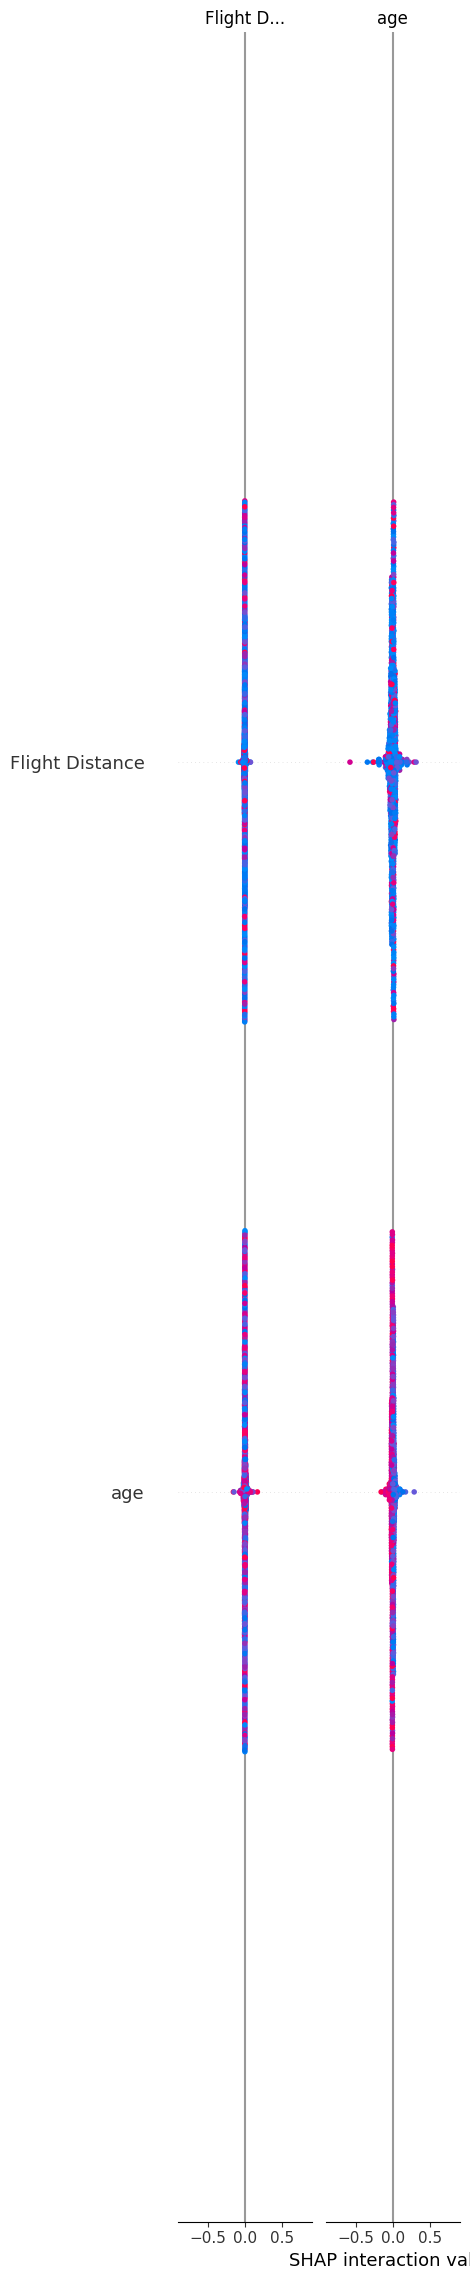

In [162]:
shap.summary_plot(shap_values, plot_type="bar", max_display=30, feature_names=vals.columns, features=vals)

`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [ ]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

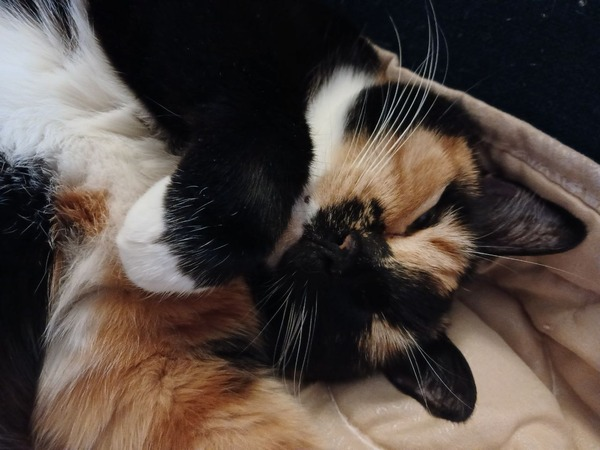

Предполагаю, что это котик Сабрины Садиех.

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

В сравнении с 5 и 6 это домашка более легкая в начале. Но к концу интерпретаторы сломали меня. Выполняла его где-то 2,5 дня, но это были ненапряжные дни, из которых можно слепить 1 целый и суетной.
По 10 балльной шкале оцениваю его на 7.